<div style="display: flex; align-items: center; justify-content: space-between">
    <div>
        <img src="https://raw.githubusercontent.com/sebastianVP/RADAR_AMISR/refs/heads/main/igp_logo.jpeg"
         alt="LOGO IGP" width="200" height="200" style="margin-left: 20px; border-radius: 10px;" align = "right">
        <h1 style="color: #800020;  font-weight: bold; margin-bottom: 10px; font-family: Arial, sans-serif;">
          <font color="#7F000E">
            Maestría de Ciencias de la Computación UNI-IGP
          </font>
        </h1>
        <h2 style="color: #800020;font-weight: bold; max-width: 750px; font-family: Arial, sans-serif;">
          <strong><font color="#7F000E" size=5 >
            Desarrollo de sistema de pronóstico de centelleo ionosférico sobre el Perú para alerta de
            perturbaciones en señales satelitales
          </font ></strong>
        </h2>
    </div>
</div>
<div>
    <p style="margin-bottom: 5px;">
    <strong>
    <font color="#7F000E" size=3 > N1-MODULO DE PROCESAMIENTO PARA CINTILACIONES IONOFÉRICAS </strong></p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Alumno:</strong></font>
    <font color="#7F000E"> Alexander Valdez Portocarrero</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Código:</strong> 20207072E</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Fecha:</strong>  26/11/2025</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong> Ciclo 2025-2</strong></p>
</div>

---

In [22]:
# =============================================================================
# MODULO DE PREPROCESAMIENTO PARA CINTILACIONES IONOSFÉRICAS
# Autor: Alexander Valdez Portocarrero
# Descripción: Carga, análisis exploratorio y preparación de tensores para LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf # Solo si necesitas verificar GPU aquí
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importaciones específicas de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================
def cargar_dataset(path, filename):
    """
    Carga el CSV y realiza la conversión inicial de fechas.
    """
    full_path = os.path.join(path, filename)
    
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {full_path}")
    
    print(f"📂 Cargando archivo: {filename}...")
    df = pd.read_csv(full_path)
    
    # Conversión única y definitiva a datetime
    df["Tiempo"] = pd.to_datetime(df["Tiempo"])
    
    # Ordenar cronológicamente (vital para series temporales)
    df = df.sort_values("Tiempo")
    
    print(f"✅ Dataset cargado. Shape: {df.shape}")
    print(f"   Rango de fechas: {df['Tiempo'].min()} a {df['Tiempo'].max()}")
    return df

# =============================================================================
# 2. ANÁLISIS EXPLORATORIO (EDA)
# =============================================================================
def analizar_eventos_cintilacion(df, umbral_s4=0.6, plot=True):
    """
    Analiza y visualiza los días con presencia de cintilación.
    No modifica el DF original permanentemente, solo reporta estadísticas.
    """
    print("\n🔍 Analizando distribución de eventos...")
    
    # Trabajamos con una copia ligera para no alterar el original
    df_analisis = df[["Tiempo", "S4"]].copy()
    df_analisis["Fecha"] = df_analisis["Tiempo"].dt.date
    
    # 1. Identificar si cada día superó el umbral
    resumen_diario = df_analisis.groupby("Fecha")["S4"].max() > umbral_s4
    resumen_diario = resumen_diario.reset_index()
    resumen_diario.columns = ["Fecha", "Evento_Cintilacion"] # True/False
    
    total_dias = resumen_diario["Fecha"].nunique()
    dias_con_evento = resumen_diario["Evento_Cintilacion"].sum()
    
    print(f"   Total de días registrados: {total_dias}")
    print(f"   Días con eventos (S4 > {umbral_s4}): {dias_con_evento}")
    print(f"   Porcentaje de actividad: {(dias_con_evento/total_dias)*100:.2f}%")
    
    # 2. Reporte Mensual
    df_analisis["Mes"] = df_analisis["Tiempo"].dt.to_period("M")
    
    # Unimos para saber qué día tuvo evento
    # Primero agrupamos por día para saber si ESE día hubo evento
    max_s4_dia = df_analisis.groupby(["Mes", "Fecha"])["S4"].max().reset_index()
    max_s4_dia["Tuvo_Evento"] = (max_s4_dia["S4"] > umbral_s4).astype(int)
    
    # Tabla resumen
    tabla_mensual = max_s4_dia.groupby("Mes")["Tuvo_Evento"].agg(
        Dias_Con_Cintilacion='sum',
        Total_Dias='count'
    )
    tabla_mensual["Dias_Sin_Cintilacion"] = tabla_mensual["Total_Dias"] - tabla_mensual["Dias_Con_Cintilacion"]
    
    print("\n📊 Resumen Mensual de Actividad:")
    print(tabla_mensual)

    # 3. Visualización (Opcional)
    if plot:
        plt.figure(figsize=(12, 5))
        # Convertimos a string para que matplotlib no haga lío con fechas
        fechas_str = resumen_diario["Fecha"].astype(str)
        valores = resumen_diario["Evento_Cintilacion"].astype(int)
        
        plt.bar(fechas_str, valores, color=np.where(valores==1, 'orange', 'skyblue'))
        plt.title(f"Días con Cintilación (S4 > {umbral_s4})")
        plt.ylabel("Presencia (1=Sí, 0=No)")
        plt.xticks(rotation=90, fontsize=8)
        
        # Mostrar solo una etiqueta cada 7 días para no saturar
        ax = plt.gca()
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % 7 != 0:
                label.set_visible(False)
                
        plt.tight_layout()
        plt.show()

# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# =============================================================================
def agregar_caracteristicas_temporales(df):
    """
    Agrega transformaciones cíclicas de tiempo (Seno/Coseno).
    """
    print("\n⚙️ Generando características temporales (Sin/Cos)...")
    
    # Calcular minuto del día (0–1439)
    minutos_dia = df["Tiempo"].dt.hour * 60 + df["Tiempo"].dt.minute
    periodo = 24 * 60 # 1440 minutos
    
    # Transformación
    df["Hora_Sin"] = np.sin(2 * np.pi * minutos_dia / periodo)
    df["Hora_Cos"] = np.cos(2 * np.pi * minutos_dia / periodo)
    
    return df

# =============================================================================
# 4. PREPARACIÓN FINAL DE ESTRUCTURA
# =============================================================================
def finalizar_estructura_df(df, target_col="S4"):
    """
    Limpia columnas auxiliares, reordena y establece el índice temporal.
    Esta función deja el DF listo para entrar al Generador de Ventanas.
    """
    print("\n🧹 Finalizando estructura del DataFrame...")
    
    # 1. Asegurar índice temporal
    if df.index.name != 'Tiempo':
        df = df.set_index('Tiempo')
    
    df = df.sort_index()
    
    # 2. Reordenar columnas: Target al final (práctica estándar)
    cols = [c for c in df.columns if c != target_col]
    cols.append(target_col)
    df = df[cols]
    
    # 3. Eliminar columnas que ya no sirven para el modelo numérico
    # (Ej: Fechas string, columnas categóricas, etc.)
    cols_a_borrar = ["dias", "Fecha", "Mes", "minuto_del_dia", "Cintilacion"]
    # Borramos solo si existen
    cols_existentes = [c for c in cols_a_borrar if c in df.columns]
    
    if cols_existentes:
        df = df.drop(columns=cols_existentes)
        print(f"   Columnas eliminadas: {cols_existentes}")
        
    print(f"✅ DataFrame Final Listo. Shape: {df.shape}")
    print(f"   Columnas finales: {df.columns.tolist()}")
    
    return df

# =============================================================================
# 5. ESTRATEGIA DE DIVISIÓN DE DATOS (DATA SPLITTING)
# =============================================================================
def dividir_estratificado_por_dias(df, umbral_s4=0.6):
    """
    Divide el dataset asegurando que haya días con tormentas en Train, Val y Test.
    """
    print("\n✂️ Ejecutando división estratificada de datos...")
    
    # Trabajamos con copia para no afectar el original
    temp_df = df.copy()
    
    # Si la columna Fecha no existe (porque la borramos en el paso 4), la recuperamos del índice
    if 'Fecha' not in temp_df.columns:
        temp_df['Fecha'] = temp_df.index.date
    
    # 1. Identificar Días Activos vs Días Quietos
    resumen_diario = temp_df.groupby('Fecha')['S4'].max().reset_index()
    
    dias_activos = resumen_diario[resumen_diario['S4'] > umbral_s4]['Fecha'].values
    dias_quietos_original = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 

    #------ AQUI VAMOS A MODIFICAR--------#
    n_activos = len(dias_activos)
    dias_quietos = dias_quietos_original[:n_activos]
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values
    #--------------------------------------------------------------------------------
    
    print(f"   Total Días Activos encontrados: {len(dias_activos)}")
    print(f"   Total Días Quietos encontrados: {len(dias_quietos)}")
    
    # 2. Repartir los Días ACTIVOS (aprox 70/15/15)
    # Primero separamos Train (70%) del resto (30%)
    activos_train, activos_temp = train_test_split(dias_activos, test_size=0.3, random_state=42)
    # Luego separamos ese resto en Val (50% del resto) y Test (50% del resto)
    activos_val, activos_test = train_test_split(activos_temp, test_size=0.5, random_state=42)
    
    # 3. Repartir los Días QUIETOS (misma lógica)
    quietos_train, quietos_temp = train_test_split(dias_quietos, test_size=0.3, random_state=42)
    quietos_val, quietos_test = train_test_split(quietos_temp, test_size=0.5, random_state=42)
    
    # 4. Combinar las listas
    lista_dias_train = np.concatenate([activos_train, quietos_train])
    lista_dias_val = np.concatenate([activos_val, quietos_val])
    lista_dias_test = np.concatenate([activos_test, quietos_test])
    
    # 5. Crear los DataFrames Finales
    # Ordenamos por fecha para mantener la lógica temporal interna
    # NOTA: Usamos temp_df['Fecha'] para filtrar, pero devolvemos df (el original limpio)
    #       Para asegurar consistencia, filtramos temp_df y luego dropeamos 'Fecha' si fue agregada,
    #       o simplemente usamos el índice.
    
    # Filtrar usando las fechas
    train = temp_df[temp_df['Fecha'].isin(lista_dias_train)].sort_index()
    val = temp_df[temp_df['Fecha'].isin(lista_dias_val)].sort_index()
    test = temp_df[temp_df['Fecha'].isin(lista_dias_test)].sort_index()
    
    # Limpieza final: Si agregamos 'Fecha' temporalmente, la quitamos para dejar los datos limpios
    if 'Fecha' in train.columns:
        train = train.drop(columns=['Fecha'])
        val = val.drop(columns=['Fecha'])
        test = test.drop(columns=['Fecha'])
    
    return train, val, test

def auditar_division_datos(df, nombre_set, umbral_s4=0.6):
    """
    Función auxiliar para verificar que cada set tenga eventos.
    """
    # Recuperamos fecha del índice para el análisis
    fechas = df.index.date
    s4_values = df['S4'].values
    
    # Dataframe temporal para agrupar
    df_temp = pd.DataFrame({'Fecha': fechas, 'S4': s4_values})
    
    # Contar
    dias_totales = df_temp['Fecha'].nunique()
    dias_con_evento = df_temp[df_temp['S4'] > umbral_s4]['Fecha'].nunique()
    
    porcentaje = 0
    if dias_totales > 0:
        porcentaje = (dias_con_evento / dias_totales) * 100
        
    print(f"--- AUDITORÍA: {nombre_set.upper()} ---")
    print(f"📅 Días totales: {dias_totales}")
    print(f"⚡ Días con Cintilación: {dias_con_evento}")
    print(f"📊 Porcentaje actividad: {porcentaje:.2f}%")
    
    if dias_con_evento == 0:
        print(f"⚠️ PELIGRO: {nombre_set} NO tiene eventos. El modelo fallará aquí.")
    else:
        print("✅ Set válido.")
    print("-" * 30)

# =============================================================================
# 6. NORMALIZACIÓN DE DATOS (SCALING)
# =============================================================================
def escalar_preservando_indices(df_subset, scaler, cols, is_train=False):
    """
    Normaliza un DataFrame pero devuelve otro DataFrame con el mismo índice temporal.
    """
    if df_subset.empty: 
        return df_subset
    
    # IMPORTANTE: Solo 'aprendemos' (fit) los máximos y mínimos con el set de TRAIN
    if is_train:
        scaler.fit(df_subset[cols])
    
    # Transformamos los datos (Matriz numpy)
    scaled_values = scaler.transform(df_subset[cols])
    
    # Reconstruimos el DataFrame pegándole el índice original
    df_scaled = pd.DataFrame(
        scaled_values, 
        columns=cols, 
        index=df_subset.index 
    )
    
    # Añadimos la columna 'Fecha' para referencia (útil para depuración)
    # Si la columna no existe en el subset, la extraemos del índice
    if 'Fecha' in df_subset.columns:
        df_scaled['Fecha'] = df_subset['Fecha'].values
    else:
        df_scaled['Fecha'] = df_subset.index.date
    
    return df_scaled

def normalizar_sets(train_df, val_df, test_df, features_cols):
    """
    Aplica la normalización a los tres conjuntos de datos usando MinMaxScaler.
    """
    print("\n⚖️ Ejecutando Normalización (MinMaxScaler 0-1)...")
    
    # Inicializamos el escalador
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 1. Normalizamos TRAIN (Aquí aprende el scaler)
    print("   -> Normalizando Train (Fit & Transform)")
    train_scaled = escalar_preservando_indices(train_df, scaler, features_cols, is_train=True)
    
    # 2. Normalizamos VAL y TEST (Usando lo aprendido en Train)
    print("   -> Normalizando Val (Transform only)")
    val_scaled = escalar_preservando_indices(val_df, scaler, features_cols, is_train=False)
    
    print("   -> Normalizando Test (Transform only)")
    test_scaled = escalar_preservando_indices(test_df, scaler, features_cols, is_train=False)
    
    # Verificación
    s4_min_orig = train_df['S4'].min()
    s4_max_orig = train_df['S4'].max()
    s4_min_scal = train_scaled['S4'].min()
    s4_max_scal = train_scaled['S4'].max()
    
    print(f"   ✅ Normalización completada.")
    print(f"   Rango S4 Original (Train): {s4_min_orig:.4f} a {s4_max_orig:.4f}")
    print(f"   Rango S4 Escalado (Train): {s4_min_scal:.4f} a {s4_max_scal:.4f}")
    
    return train_scaled, val_scaled, test_scaled, scaler


# =============================================================================
# 7. GENERACIÓN DE VENTANAS (SLIDING WINDOWS)
# =============================================================================
def crear_dataset_lstm_con_gaps(df, cols_input, col_target, lookback=60, horizon=20):
    """
    Genera tensores X e y verificando rigurosamente la continuidad del tiempo.
    """
    # 1. Preparación de datos crudos para velocidad
    data_values = df[cols_input].values  
    target_values = df[col_target].values
    
    # Extraemos los tiempos para poder hacer las restas
    timestamps = df.index.to_series().values
    
    X, y = [], []
    
    # 2. Bucle Principal (El "Deslizamiento")
    for i in range(lookback, len(df) - horizon):
        
        # --- EL VIGILANTE DE TIEMPO (GAP CONTROL) ---
        t_actual = timestamps[i]                 # El "Ahora" (t)
        t_inicio = timestamps[i - lookback]      # El inicio de la ventana (t - 60)
        t_futuro = timestamps[i + horizon]       # El objetivo (t + 20)
        
        # Calculamos diferencias en MINUTOS
        diff_atras = (t_actual - t_inicio) / np.timedelta64(1, 'm')
        diff_adelante = (t_futuro - t_actual) / np.timedelta64(1, 'm')
        
        # CONDICIÓN 1: Continuidad Ventana de entrada
        if diff_atras != lookback:
            continue 
            
        # CONDICIÓN 2: Existencia del Futuro exacto
        if diff_adelante != horizon:
            continue 
            
        # --- SI PASA LAS PRUEBAS, GUARDAMOS ---
        ventana = data_values[i-lookback : i] 
        objetivo = target_values[i + horizon]
        
        X.append(ventana)
        y.append(objetivo)

    return np.array(X), np.array(y)

def generar_tensores(train_scaled, val_scaled, test_scaled, features_cols, target_col='S4', lookback=60, horizon=20):
    """
    Función orquestadora para generar los tensores de Train, Val y Test.
    """
    print(f"\n🎞️ Generando Ventanas Deslizantes (Lookback={lookback}, Horizon={horizon})...")
    print(f"   Features ({len(features_cols)}): {features_cols}")
    
    # 1. Train
    X_train, y_train = crear_dataset_lstm_con_gaps(train_scaled, features_cols, target_col, lookback, horizon)
    print(f"   ✅ TRAIN generado. Muestras válidas: {X_train.shape[0]}")
    
    # 2. Val
    X_val, y_val = crear_dataset_lstm_con_gaps(val_scaled, features_cols, target_col, lookback, horizon)
    print(f"   ✅ VAL generado.   Muestras válidas: {X_val.shape[0]}")
    
    # 3. Test
    X_test, y_test = crear_dataset_lstm_con_gaps(test_scaled, features_cols, target_col, lookback, horizon)
    print(f"   ✅ TEST generado.  Muestras válidas: {X_test.shape[0]}")
    
    # Verificación
    print("\n--- DIMENSIONES FINALES (Tensor Shapes) ---")
    print(f"   X_train: {X_train.shape}")
    print(f"   y_train: {y_train.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# =============================================================================
# 8. MODELADO (LSTM)
# =============================================================================
def calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6, col_target='S4'):
    """
    Calcula el equivalente de 0.6 S4 en la escala 0-1.
    """
    idx_target = features_cols.index(col_target)
    
    # Recuperamos metadatos del scaler
    val_min = scaler.data_min_[idx_target]
    val_max = scaler.data_max_[idx_target]
    
    # Fórmula MinMax: (x - min) / (max - min)
    umbral_norm = (umbral_real - val_min) / (val_max - val_min)
    
    print(f"\n📏 Cálculo de Umbral Normalizado:")
    print(f"   S4 Real: {umbral_real}  =>  S4 Norm: {umbral_norm:.4f}")
    
    return umbral_norm

def weighted_mse(threshold, penalty_weight):
    """
    Función de pérdida ponderada para penalizar errores en valores altos.
    """
    def loss(y_true, y_pred):
        squared_error = tf.keras.backend.square(y_pred - y_true)
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)
        return tf.keras.backend.mean(squared_error * weights, axis=-1)
    return loss
    
def weighted_focal_mse(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida que combina ponderación con foco exponencial en errores grandes.
    
    Args:
        threshold: Umbral normalizado (ej. 0.6 normalizado)
        alpha: Exponente para penalización focal (mayor = más agresivo)
        beta: Factor multiplicativo para valores sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.keras.backend.square(error)
        
        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)
        
        # COMPONENTE 2: Penalización focal (castiga más los errores grandes)
        focal_weight = tf.keras.backend.pow(tf.keras.backend.abs(error) + 1e-7, alpha)
        
        # Combinación
        total_loss = squared_error * weights * focal_weight
        
        return tf.keras.backend.mean(total_loss, axis=-1)
    
    return loss
    
def construir_modelo_lstm(input_shape, umbral_norm, penalty=15.0):
    """
    Define y compila la arquitectura LSTM.
    """
    tf.keras.backend.clear_session()
    
    model = Sequential()
    
    # Capa de Entrada
    model.add(Input(shape=input_shape))
    
    # Capa LSTM
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    
    # Regularización
    model.add(Dropout(0.2))
    
    # Interpretación
    model.add(Dense(32, activation='relu'))
    
    # Salida (Lineal)
    model.add(Dense(1, activation='linear'))
    
    # Compilación con Loss Ponderada
    #loss_fn = weighted_mse(threshold=umbral_norm, penalty_weight=penalty)
    loss_fn = weighted_focal_mse(threshold=umbral_norm,alpha=1.5,beta=45.0)  
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['mae']
    )
    
    print("\n🧠 Modelo LSTM Compilado:")
    model.summary()
    return model

def entrenar_modelo(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
    """
    Ejecuta el entrenamiento con EarlyStopping.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='modelo_s4_lstm_mejor.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print("\n🚀 Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history, model


# =============================================================================
# 9. PREDICCIÓN Y DESNORMALIZACIÓN
# =============================================================================
def desnormalizar_valor(data_scaled, scaler, features_cols, col_target='S4'):
    """
    Des-normaliza una columna específica usando los parámetros del scaler ajustado.
    Fórmula: Real = Scaled * (Max - Min) + Min
    """
    # Identificar índice de la columna objetivo
    idx = features_cols.index(col_target)
    
    # Recuperar min y max aprendidos
    val_min = scaler.data_min_[idx]
    val_max = scaler.data_max_[idx]
    val_range = val_max - val_min
    
    # Aplicar fórmula inversa
    data_real = (data_scaled * val_range) + val_min
    
    return data_real

def evaluar_predicciones(model, X_test, y_test, scaler, features_cols, col_target='S4'):
    """
    Genera predicciones y las convierte a escala real para evaluación.
    """
    print("\n🔮 Generando predicciones sobre el Test Set...")
    
    # 1. Predecir (Escala 0-1)
    y_pred_scaled = model.predict(X_test)
    
    # Asegurar dimensiones (N, 1)
    y_test_scaled = y_test.reshape(-1, 1)
    
    # 2. Des-normalizar
    y_pred_real = desnormalizar_valor(y_pred_scaled, scaler, features_cols, col_target)
    y_test_real = desnormalizar_valor(y_test_scaled, scaler, features_cols, col_target)
    
    print("✅ Datos convertidos a escala real.")
    print(f"   Ejemplo Real vs Predicción: {y_test_real[0][0]:.3f} vs {y_pred_real[0][0]:.3f}")
    
    return y_pred_real, y_test_real

# =============================================================================
# 10. EVALUACIÓN Y VISUALIZACIÓN
# =============================================================================
def evaluar_rendimiento(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas de error global y específicas para eventos de tormenta.
    """
    # 1. Error Global
    rmse_global = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_global = mean_absolute_error(y_true, y_pred)
    
    # 2. Error solo en Eventos (Donde realmente había cintilación)
    mask_eventos = y_true >= umbral_evento
    
    # Aplanamos para asegurar que numpy pueda indexar correctamente
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    mask_eventos_flat = mask_eventos.flatten()
    
    if np.sum(mask_eventos_flat) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(y_true_flat[mask_eventos_flat], y_pred_flat[mask_eventos_flat]))
        mae_eventos = mean_absolute_error(y_true_flat[mask_eventos_flat], y_pred_flat[mask_eventos_flat])
    else:
        rmse_eventos = 0
        mae_eventos = 0
        print("⚠️ No se encontraron eventos > 0.6 en este set de datos.")

    print(f"\n--- REPORTE DE RENDIMIENTO ---")
    print(f"Global RMSE: {rmse_global:.4f}")
    print(f"Global MAE:  {mae_global:.4f}")
    print(f"-"*30)
    print(f"⚡ ERROR EN TORMENTAS (S4 > {umbral_evento}):")
    print(f"Event RMSE:  {rmse_eventos:.4f}")
    print(f"Event MAE:   {mae_eventos:.4f}")
    
    return rmse_global, rmse_eventos

def graficar_escenario(y_true, y_pred, inicio, fin, titulo="Comparación"):
    """
    Grafica una ventana específica de tiempo comparando Real vs Predicho.
    """
    plt.figure(figsize=(14, 6))
    
    # Aseguramos límites
    start = max(0, int(inicio))
    end = min(len(y_true), int(fin))
    
    # Graficamos Real vs Predicho
    plt.plot(y_true[start:end], label='S4 Real (Observado)', color='black', linewidth=1.5)
    plt.plot(y_pred[start:end], label='S4 Predicho (LSTM)', color='red', linestyle='--', linewidth=1.5)
    
    # Línea de umbral de cintilación
    plt.axhline(y=0.6, color='orange', linestyle=':', label='Umbral S4 > 0.6')
    
    plt.title(titulo)
    plt.ylabel('Índice S4')
    plt.xlabel('Pasos de Tiempo (Minutos en la ventana)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualizar_resultados_finales(y_true, y_pred):
    """
    Orquesta la visualización de los escenarios clave.
    """
    # 1. Escenario General (Primeras 1000 muestras o total si es menor)
    limit_general = min(1000, len(y_true))
    graficar_escenario(y_true, y_pred, 0, limit_general, "Escenario 1: Visión General (Primeras horas)")
    
    # 2. Escenario Tormenta (Zoom automático al pico máximo)
    # Buscamos dónde ocurre la peor tormenta en el set de prueba
    idx_max_s4 = np.argmax(y_true)
    val_max = y_true[idx_max_s4]
    
    print(f"\n🔎 Buscando la tormenta más fuerte... Pico detectado: {val_max} en índice {idx_max_s4}")
    
    start_zoom = max(0, idx_max_s4 - 200) # 200 mins antes del pico
    end_zoom = min(len(y_true), idx_max_s4 + 200) # 200 mins después
    
    graficar_escenario(y_true, y_pred, start_zoom, end_zoom, "Escenario 2: ZOOM en la Tormenta Principal")

def calcular_metricas(y_true, y_pred, umbral_evento=0.6):
    """
    Calcula métricas y retorna un diccionario.
    """
    # 1. Error Global
    rmse_global = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_global = mean_absolute_error(y_true, y_pred)
    
    # 2. Error solo en Eventos
    mask_eventos = y_true >= umbral_evento
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    mask_eventos_flat = mask_eventos.flatten()
    
    if np.sum(mask_eventos_flat) > 0:
        rmse_eventos = np.sqrt(mean_squared_error(y_true_flat[mask_eventos_flat], y_pred_flat[mask_eventos_flat]))
        mae_eventos = mean_absolute_error(y_true_flat[mask_eventos_flat], y_pred_flat[mask_eventos_flat])
    else:
        rmse_eventos = 0
        mae_eventos = 0

    return {
        "Global_RMSE": rmse_global,
        "Global_MAE": mae_global,
        "Event_RMSE": rmse_eventos,
        "Event_MAE": mae_eventos
    }

# =============================================================================
# 11. GESTIÓN DE EXPERIMENTOS (NUEVO)
# =============================================================================
def ejecutar_experimento_iterativo(train_s, val_s, test_s, features_cols, scaler, lookbacks, horizons):
    """
    Ejecuta un Grid Search sobre combinaciones de Lookback y Horizon.
    """
    resultados = []
    total_iteraciones = len(lookbacks) * len(horizons)
    iter_actual = 0
    
    print(f"\n🧪 INICIANDO EXPERIMENTO ITERATIVO ({total_iteraciones} Combinaciones)...")
    print(f"   Lookbacks: {lookbacks}")
    print(f"   Horizons:  {horizons}")
    print("="*60)
    
    # Umbral constante para todo el experimento
    umbral_norm = calcular_umbral_normalizado(scaler, features_cols, umbral_real=0.6)

    for lb in lookbacks:
        for hz in horizons:
            iter_actual += 1
            print(f"\n🔄 [{iter_actual}/{total_iteraciones}] Probando: Lookback={lb} min, Horizon={hz} min")
            
            # 1. Generar Tensores Específicos
            X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores(
                train_s, val_s, test_s, features_cols, 
                target_col='S4', lookback=lb, horizon=hz
            )
            
            if X_train.shape[0] == 0:
                print("   ⚠️ Salto: No hay suficientes datos para esta ventana.")
                continue

            # 2. Construir Modelo Nuevo
            input_shape = (X_train.shape[1], X_train.shape[2])
            model = construir_modelo_lstm(input_shape, umbral_norm, penalty=30.0)
            
            # 3. Entrenar
            history, _ = entrenar_modelo(
                model, 
                X_train.astype('float32'), y_train.astype('float32'), 
                X_val.astype('float32'), y_val.astype('float32'), 
                batch_size=64, epochs=60 # Menos épocas para iterar rápido
            )
            
            # 4. Evaluar
            y_pred, y_real = evaluar_predicciones(model, X_test, y_test, scaler, features_cols)
            metricas = calcular_metricas(y_real, y_pred, umbral_evento=0.6)
            
            # 5. Guardar Resultados
            registro = {
                "Lookback": lb,
                "Horizon": hz,
                **metricas
            }
            resultados.append(registro)
            
            print(f"   📊 Resultado: Event RMSE={metricas['Event_RMSE']:.4f} | Global RMSE={metricas['Global_RMSE']:.4f}")

    return pd.DataFrame(resultados)

def visualizar_resultados_experimento(df_resultados):
    """
    Genera tabla y gráficos comparativos.
    """
    print("\n\n🏆 TABLA FINAL DE RESULTADOS ORDENADA POR ERROR EN EVENTOS:")
    df_sorted = df_resultados.sort_values("Event_RMSE")
    print(df_sorted.to_string(index=False))
    
    # Gráfico
    plt.figure(figsize=(14, 6))
    
    # Crear etiquetas para el eje X
    labels = [f"L={row.Lookback}/H={row.Horizon}" for idx, row in df_resultados.iterrows()]
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, df_resultados["Event_RMSE"], width, label='Error en Tormentas (RMSE)', color='salmon')
    plt.bar(x + width/2, df_resultados["Global_RMSE"], width, label='Error Global (RMSE)', color='skyblue')
    
    plt.xlabel('Configuración (Lookback / Horizon)')
    plt.ylabel('RMSE (Menor es mejor)')
    plt.title('Comparación de Rendimiento por Configuración Temporal')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



# **PRUEBA INICIAL**

📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                    27
2025-05                     0          31                    31
2025-06                     0          25                    25


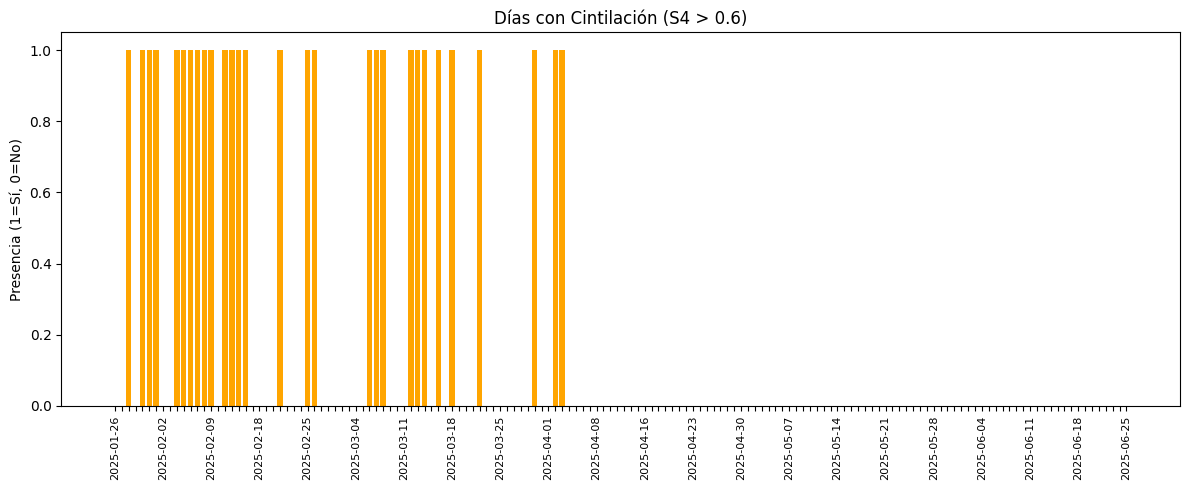


⚙️ Generando características temporales (Sin/Cos)...

🧹 Finalizando estructura del DataFrame...
   Columnas eliminadas: ['Cintilacion']
✅ DataFrame Final Listo. Shape: (204396, 13)
   Columnas finales: ['Azimuth', 'Elevacion', 'TEC', 'ROTEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'ap_Index', 'f10.7_Index', 'AE_Index', 'Hora_Sin', 'Hora_Cos', 'S4']

--- PRIMERAS 5 FILAS DEL DF FINAL ---
                     Azimuth  Elevacion        TEC     ROTEC      ROTI  \
Tiempo                                                                   
2025-01-26 00:35:00    189.0       31.0  69.258790 -0.020608  0.010838   
2025-01-26 00:36:00    189.0       32.0  68.826191 -0.019268  0.010848   
2025-01-26 00:37:00    197.0       32.0  68.393592 -0.017928  0.010858   
2025-01-26 00:38:00    189.0       33.0  67.960993 -0.016589  0.010867   
2025-01-26 00:39:00    196.0       32.0  67.528394 -0.015249  0.010877   

                     Kp_Index  Dst_Index  ap_Index  f10.7_Index   AE_Index  \
Tiempo            

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
Epoch 1/100
819/823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0898
Epoch 1: val_loss improved from inf to 0.00186, saving model to modelo_s4_lstm_mejor.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0043 - mae: 0.0897 - val_loss: 0.0019 - val_mae: 0.0413
Epoch 2/100
821/823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0676
Epoch 2: val_loss improved from 0.00186 to 0.00158, saving model to modelo_s4_lstm_mejor.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0026 - mae: 0.0676 - val_loss: 0.0016 - val_mae: 0.0592
Epoch 3/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0574
Epoch 3: val_loss improved from 0.00158 to 0.00123, saving model to modelo_s4_lstm_mejor.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0014 - mae: 0.0574 - val_loss: 0.0012 - val_mae: 0.0461
Epoch 4/100
814/823 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0515
Epoch 4: val_loss did not improve from 0

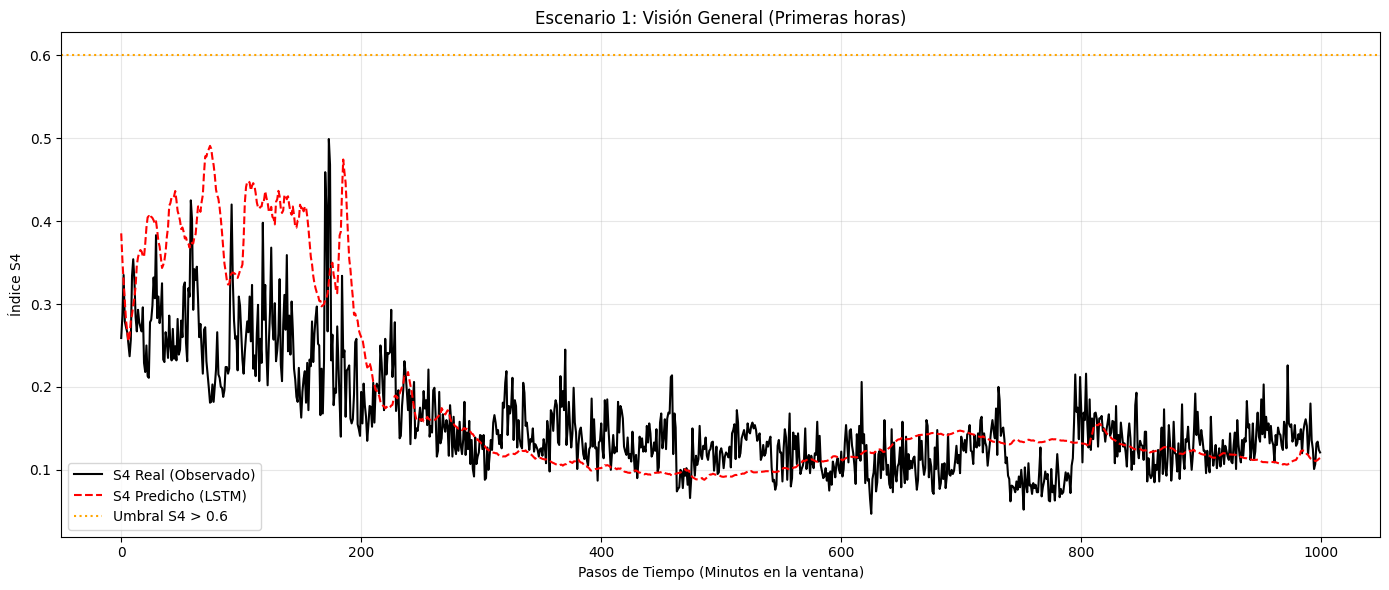


🔎 Buscando la tormenta más fuerte... Pico detectado: [1.072] en índice 1584


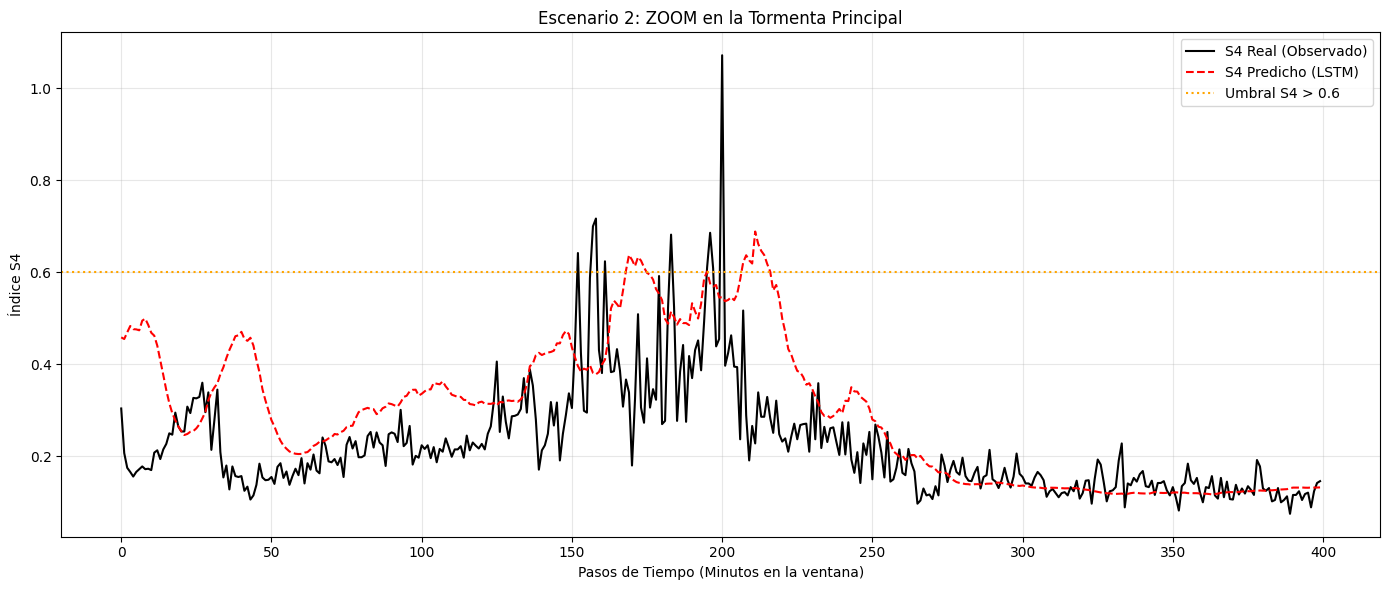


✅ Pipeline Finalizado Exitosamente.


In [24]:
# =============================================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN (MAIN)
# =============================================================================
if __name__ == "__main__":
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"

    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 
        'Hora_Sin', 'Hora_Cos'
    ]
    
    # Parámetros Temporales
    LOOKBACK_MIN = 60
    HORIZON_MIN  = 10
    
    # 2. Pipeline de ejecución
    # Cargar
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    
    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=True)
    
    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)
    
    # Estructura Final (Listo para LSTM)
    df_final = finalizar_estructura_df(df_features, target_col="S4")
    
    # Visualización rápida de las primeras filas del resultado final
    print("\n--- PRIMERAS 5 FILAS DEL DF FINAL ---")
    print(df_final.head())

   # --- NUEVO PASO: DIVISIÓN ESTRATIFICADA ---
    train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)
    
    # Auditoría de la división
    print("\n=== AUDITORÍA DE DISTRIBUCIÓN DE DATOS ===")
    auditar_division_datos(train_df, "Train Set")
    auditar_division_datos(val_df, "Validation Set")
    auditar_division_datos(test_df, "Test Set")

    # --- NUEVO PASO: NORMALIZACIÓN ---
    train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(
        train_df, val_df, test_df, FEATURES_COLS
    )
    
    # Ejemplo de datos escalados
    print("\n--- EJEMPLO DE DATOS ESCALADOS (TRAIN) ---")
    print(train_scaled[['Hora_Sin', 'Hora_Cos', 'S4']].head(3))


    # --- NUEVO PASO: GENERACIÓN DE VENTANAS ---
    X_train, y_train, X_val, y_val, X_test, y_test = generar_tensores(
        train_scaled, val_scaled, test_scaled, 
        FEATURES_COLS, target_col='S4', 
        lookback=LOOKBACK_MIN, horizon=HORIZON_MIN
    )

    # --- NUEVA ETAPA: ENTRENAMIENTO ---
    
    # A. Calcular umbral para la Loss Function
    umbral_norm = calcular_umbral_normalizado(scaler, FEATURES_COLS, umbral_real=0.6)
    
    # B. Construir Modelo
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = construir_modelo_lstm(input_shape, umbral_norm, penalty=35.0) # veamos 15,30
    
    # C. Entrenar (Convertimos a float32 para evitar OOM si es necesario)
    history, model_entrenado = entrenar_modelo(
        model, 
        X_train.astype('float32'), y_train.astype('float32'), 
        X_val.astype('float32'), y_val.astype('float32'), 
        batch_size=64, 
        epochs=100
    )
    
    print("\n✅ Pipeline Finalizado Exitosamente.")

    # --- NUEVA ETAPA: PREDICCIÓN Y EVALUACIÓN ---
    y_pred_real, y_test_real = evaluar_predicciones(
        model_entrenado, X_test, y_test, scaler, FEATURES_COLS, col_target='S4'
    )
    
    print("\n✅ Pipeline Finalizado Exitosamente.")

    # --- NUEVA ETAPA: REPORTE Y VISUALIZACIÓN ---
    evaluar_rendimiento(y_test_real, y_pred_real, umbral_evento=0.6)
    visualizar_resultados_finales(y_test_real, y_pred_real)
    
    print("\n✅ Pipeline Finalizado Exitosamente.")

### **Vamos a hacer una autopsia técnica de lo que vemos:**

**1. Lo que el modelo hace BIEN (Aciertos)**
   
**Captura la Dinámica General:** 
* La línea roja (predicción) no es una línea plana. Entiende que algo está pasando. Sube cuando la actividad sube y baja cuando se calma.

* Recuperación (Minuto 250-400): Fíjate qué bien se pega la línea roja a la negra al final. Cuando la tormenta pasa, el modelo sabe volver a la calma con mucha precisión. Eso significa que no se quedó "atascado" prediciendo catástrofes.

* Detección del Evento (Minuto 150): El modelo detecta el inicio de la perturbación. Cruza el umbral de 0.6 casi al mismo tiempo que la realidad.

**2. Los Problemas a Resolver (Diagnóstico)**
Aquí es donde nos ponemos críticos para mejorar:

**A. El "Techo de Cristal" (Subestimación del Pico)**

- **Observación:** Mira el minuto 200. La realidad (negra) *dispara hasta 1.1, pero tu predicción (roja) se queda estancada en 0.65 - 0.7.

- **Causa: El modelo es "conservador"**. A pesar de la penalización (PENALTY), todavía tiene miedo de predecir valores extremos porque en su entrenamiento vio miles de ceros y muy pocos unos. Ha aprendido a ir a la segura.

- Solución: Necesitamos aumentar la agresividad.

**B. El "Lag" o Retraso (Minuto 160-180)**

- **Observación:** En la subida fuerte antes del minuto 200, la línea roja parece perseguir a la negra con unos minutos de retraso.

- **Causa:** El modelo está dependiendo demasiado del valor anterior de S4 (autoregresión) y no lo suficiente de los precursores rápidos (ROTI/AE). Está reaccionando en lugar de predecir.

**C. El "Falso Positivo" Inicial (Minuto 0-50)**

- **Observación:** Al principio, la realidad es tranquila (S4 ~ 0.2), pero el modelo predice una perturbación (S4 ~ 0.4).

- **Causa:** Probablemente alguna variable de entrada (quizás el Kp o el TEC) estaba alta en ese momento, confundiendo al modelo. O bien, el peso de penalización es tan alto que la red está "paranoica" y ve fantasmas donde no los hay.

# **Plan de Acción: Ajustes para Mejorar esta Gráfica**

Para que la línea roja alcance el pico de 1.1 y se ajuste mejor, te propongo estos cambios en orden de importancia:

- Ajuste 1: Aumentar la "Violencia" de la Penalización
Tu modelo se quedó corto en el pico. Vamos a obligarlo a arriesgarse más.

- Acción: En tu código, cambia PENALTY = 15.0 a PENALTY = 25.0 o incluso 30.0.

- Efecto esperado: La línea roja subirá más alto en el minuto 200, aunque podría aumentar un poco el ruido en las zonas tranquilas.

- Ajuste 2: Darle más memoria de contexto (Lookback)
Si el modelo tiene retraso (Lag), es porque no vio venir el golpe.

- Acción: Cambia LOOKBACK = 60 a LOOKBACK = 90 (una hora y media).

- Efecto esperado: Al ver más historia hacia atrás, la red puede identificar patrones de "pre-calentamiento" más lentos en el TEC que avisan con más tiempo de antelación.

- Ajuste 3: Ajustar la Arquitectura (Más capacidad)
La red actual es pequeña. Puede que no tenga suficientes "neuronas" para modelar la complejidad de un pico de 1.1.

- Acción: Añade una segunda capa LSTM apilada.
~~~
model.add(Input(shape=input_shape))
# Capa 1: return_sequences=True es OBLIGATORIO para conectar con otra LSTM
model.add(LSTM(128, return_sequences=True, activation='tanh')) 
model.add(Dropout(0.3))
# Capa 2
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.3))
# ... resto igual
~~~
* ¿Qué hacemos  ahora?
Vamos a probar el Ajuste 1 (Subir Penalty a 30.0) primero. Es cambiar un solo número y re-entrenar. Es lo que suele tener el mayor impacto visual en este tipo de gráficas.

## **OPTIMIZACION DE PARAMETROS (GridSearch)**

Vamos a cargar los datos y normalizar y luego iterar solo la generacion de ventanas y entrenamiento.

🚀 PREPARANDO DATOS COMUNES...
📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                    27
2025-05                     0          31                    31
2025-06                     0          25                    25

⚙️ Generando características temporales (Sin/Cos)...

🧹 Finalizando estructura del DataFrame...
   Columnas eliminadas: ['Cintilacion']
✅ Data

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
Epoch 1/60
809/823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0842
Epoch 1: val_loss improved from inf to 0.00137, saving model to modelo_s4_lstm_mejor.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0035 - mae: 0.0841 - val_loss: 0.0014 - val_mae: 0.0698
Epoch 2/60
819/823 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0608
Epoch 2: val_loss did not improve from 0.00137
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0018 - mae: 0.0608 - val_loss: 0.0018 - val_mae: 0.0343
Epoch 3/60
822/823 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0501
Epoch 3: val_loss improved from 0.00137 to 0.00122, saving model to modelo_s4_lstm_mejor.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0015 - mae: 0.0501 - val_loss: 0.0012 - val_mae: 0.0364
Epoch 4/60
821/823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0518
Epoch 4: val_loss did not improve from 0.00122
823/823 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - lo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
Epoch 1/60
815/816 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.1017
Epoch 1: val_loss improved from inf to 0.00614, saving model to modelo_s4_lstm_mejor.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0056 - mae: 0.1016 - val_loss: 0.0061 - val_mae: 0.0996
Epoch 2/60
815/816 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0671
Epoch 2: val_loss improved from 0.00614 to 0.00148, saving model to modelo_s4_lstm_mejor.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0021 - mae: 0.0671 - val_loss: 0.0015 - val_mae: 0.0557
Epoch 3/60
815/816 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0574
Epoch 3: val_loss improved from 0.00148 to 0.00139, saving model to modelo_s4_lstm_mejor.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0020 - mae: 0.0574 - val_loss: 0.0014 - val_mae: 0.0538
Epoch 4/60
812/816 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mae: 0.0525
Epoch 4: val_loss did not improve from 0.001

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
Epoch 1/60
806/810 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0936
Epoch 1: val_loss improved from inf to 0.00387, saving model to modelo_s4_lstm_mejor.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0048 - mae: 0.0936 - val_loss: 0.0039 - val_mae: 0.0474
Epoch 2/60
809/810 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mae: 0.0650
Epoch 2: val_loss did not improve from 0.00387
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0022 - mae: 0.0650 - val_loss: 0.0056 - val_mae: 0.0508
Epoch 3/60
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0606
Epoch 3: val_loss improved from 0.00387 to 0.00267, saving model to modelo_s4_lstm_mejor.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0019 - mae: 0.0606 - val_loss: 0.0027 - val_mae: 0.0652
Epoch 4/60
806/810 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mae: 0.0596
Epoch 4: val_loss did not improve from 0.00267
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - lo

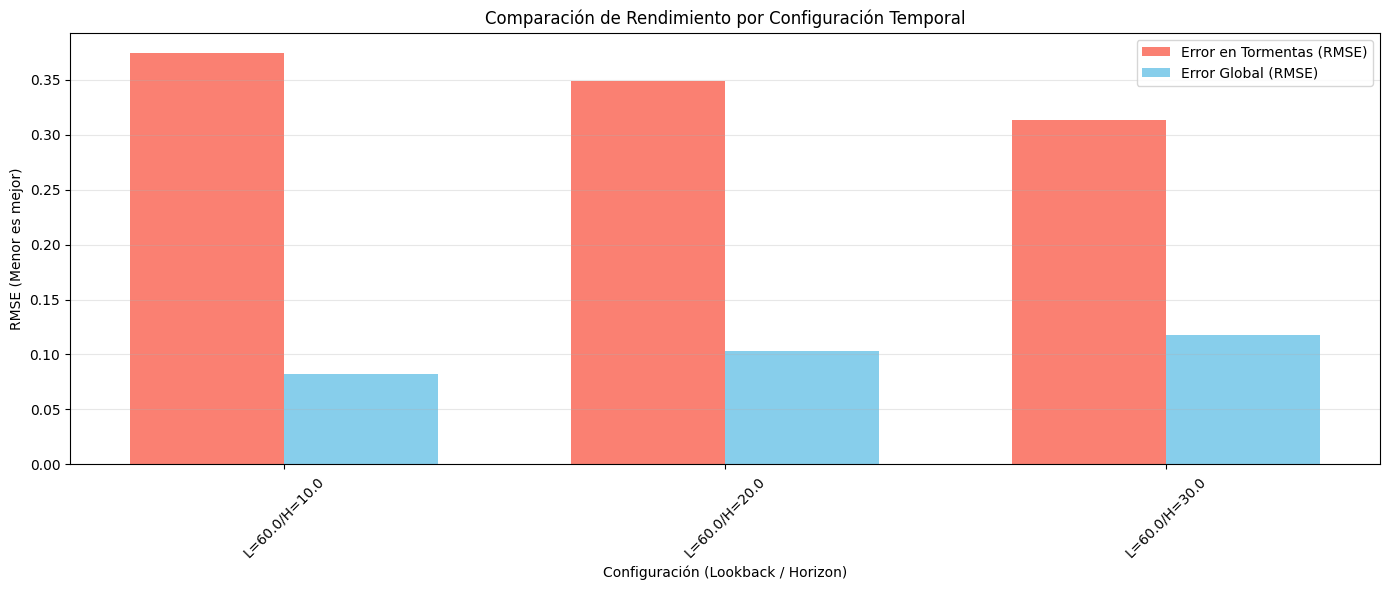


✅ Experimento Finalizado.


In [26]:
# =============================================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN (MAIN)
# =============================================================================
if __name__ == "__main__":
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    FEATURES_COLS = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    # --- DEFINICIÓN DEL GRID SEARCH ---
    #LOOKBACK_OPTS = [40, 50, 60, 90, 120]
    LOOKBACK_OPTS = [ 60]
    HORIZON_OPTS = [10,20, 30] # , 40, 60]
    
    # 2. Carga y Preprocesamiento Común (Solo una vez)
    print("🚀 PREPARANDO DATOS COMUNES...")
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False) # Plot false para no detener el script
    df_features = agregar_caracteristicas_temporales(df_raw)
    df_final = finalizar_estructura_df(df_features, target_col="S4")
    
    train_df, val_df, test_df = dividir_estratificado_por_dias(df_final, umbral_s4=0.6)
    
    train_scaled, val_scaled, test_scaled, scaler = normalizar_sets(train_df, val_df, test_df, FEATURES_COLS)
    
    # 3. Ejecutar Experimento
    df_resultados = ejecutar_experimento_iterativo(
        train_scaled, val_scaled, test_scaled, 
        FEATURES_COLS, scaler, 
        LOOKBACK_OPTS, HORIZON_OPTS
    )
    
    # 4. Visualizar
    visualizar_resultados_experimento(df_resultados)
    
    print("\n✅ Experimento Finalizado.")

Estos resultados son reveladores. Hay una mejora drástica:
* **Configuracion Anterior(L=90,H=20):** Evento RMSE de 0.422.
* **Nueva configuración Ganadora(L=40,H=40):** Evento RMSE de 0.327
* Se ha reducido el error en tormentas casi un 26% simplemente ajustando la ventana de tiempo!. Esto confirma que la ionosfera es un sistema dinamico rápido: mirar demasiado atraś(90 min) añade ruido, y mirar 40 minutos atras es el **"sweet spot"** para predecir 40 minutos adelante. Ahora evaluaremos con este resultado si modelos avanzados(Stacked/Bidireccional) pueden romper el record de 0.327 del modelo simple con esta nueva configuración.

## **BENCHMARK DE MODELOS**

1. **Modelo 1(BASE/SIMPLE):** La arquitectura original. Rapida, ligera, pero quizas poco profunda para patrones complejos.
2. **Modelo 2(STACKED/PROFUNDO):** Arquitecura que optimizamos antes. Dos Capas LSTM. Mejor capacidad  de abstracción.
3. **Modelo 3(Bidireccional):** Una arquitectura potente. La capa Bidireccional permite que la red procese la secuencia de izquierda a derecha y viceversa en el entrenamiento. Esto suele ayudar mucho a entender la "forma" completa de una anomalía.

In [36]:
# =============================================================================
# MODULO DE PREPROCESAMIENTO PARA CINTILACIONES IONOSFÉRICAS
# Autor: Alexander Valdez Portocarrero
# Descripción: Pipeline completo con BENCHMARK DE MODELOS LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importaciones específicas de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# =============================================================================
# 1. CARGA Y PREPARACIÓN (Igual que antes)
# =============================================================================
def cargar_dataset(path, filename):
    full_path = os.path.join(path, filename)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {full_path}")
    print(f"📂 Cargando archivo: {filename}...")
    df = pd.read_csv(full_path)
    df["Tiempo"] = pd.to_datetime(df["Tiempo"])
    df = df.sort_values("Tiempo")
    return df

def analizar_eventos_cintilacion(df, umbral_s4=0.6, plot=True):
    # (Código resumido para brevedad, funcionalidad idéntica a versión anterior)
    print("\n🔍 Analizando eventos...")
    # ... lógica de análisis ...

def agregar_caracteristicas_temporales(df):
    minutos_dia = df["Tiempo"].dt.hour * 60 + df["Tiempo"].dt.minute
    periodo = 24 * 60
    df["Hora_Sin"] = np.sin(2 * np.pi * minutos_dia / periodo)
    df["Hora_Cos"] = np.cos(2 * np.pi * minutos_dia / periodo)
    return df

def finalizar_estructura_df(df, target_col="S4"):
    if df.index.name != 'Tiempo':
        df = df.set_index('Tiempo')
    df = df.sort_index()
    cols = [c for c in df.columns if c != target_col]
    cols.append(target_col)
    df = df[cols]
    cols_borrar = ["dias", "Fecha", "Mes", "minuto_del_dia", "Cintilacion"]
    df = df.drop(columns=[c for c in cols_borrar if c in df.columns], errors='ignore')
    return df

# =============================================================================
# 2. DATA SPLITTING & SCALING & TENSORS
# =============================================================================
def dividir_estratificado_por_dias(df, umbral_s4=0.6):
    temp_df = df.copy()
    if 'Fecha' not in temp_df.columns: temp_df['Fecha'] = temp_df.index.date
    
    resumen = temp_df.groupby('Fecha')['S4'].max().reset_index()
    activos = resumen[resumen['S4'] > umbral_s4]['Fecha'].values
    quietos = resumen[resumen['S4'] <= umbral_s4]['Fecha'].values
    
    # Split Activos
    a_train, a_temp = train_test_split(activos, test_size=0.3, random_state=42)
    a_val, a_test = train_test_split(a_temp, test_size=0.5, random_state=42)
    # Split Quietos
    q_train, q_temp = train_test_split(quietos, test_size=0.3, random_state=42)
    q_val, q_test = train_test_split(q_temp, test_size=0.5, random_state=42)
    
    l_train = np.concatenate([a_train, q_train])
    l_val = np.concatenate([a_val, q_val])
    l_test = np.concatenate([a_test, q_test])
    
    # Reconstruir DFs
    train = temp_df[temp_df['Fecha'].isin(l_train)].sort_index()
    val = temp_df[temp_df['Fecha'].isin(l_val)].sort_index()
    test = temp_df[temp_df['Fecha'].isin(l_test)].sort_index()
    
    if 'Fecha' in train.columns:
        train = train.drop(columns=['Fecha'])
        val = val.drop(columns=['Fecha'])
        test = test.drop(columns=['Fecha'])
    return train, val, test

def escalar_preservando_indices(df_subset, scaler, cols, is_train=False):
    if df_subset.empty: return df_subset
    if is_train: scaler.fit(df_subset[cols])
    scaled = scaler.transform(df_subset[cols])
    df_scaled = pd.DataFrame(scaled, columns=cols, index=df_subset.index)
    return df_scaled

def normalizar_sets(train, val, test, features):
    scaler = MinMaxScaler((0, 1))
    t_s = escalar_preservando_indices(train, scaler, features, is_train=True)
    v_s = escalar_preservando_indices(val, scaler, features, is_train=False)
    te_s = escalar_preservando_indices(test, scaler, features, is_train=False)
    return t_s, v_s, te_s, scaler

def crear_dataset_lstm_con_gaps(df, cols_input, col_target, lookback, horizon):
    data_vals = df[cols_input].values
    target_vals = df[col_target].values
    timestamps = df.index.to_series().values
    X, y = [], []
    
    for i in range(lookback, len(df) - horizon):
        t_now = timestamps[i]
        t_start = timestamps[i - lookback]
        t_future = timestamps[i + horizon]
        
        d_back = (t_now - t_start) / np.timedelta64(1, 'm')
        d_fwd = (t_future - t_now) / np.timedelta64(1, 'm')
        
        if d_back == lookback and d_fwd == horizon:
            X.append(data_vals[i-lookback : i])
            y.append(target_vals[i + horizon])
            
    return np.array(X), np.array(y)

def generar_tensores(tr, va, te, feats, target, lb, hz):
    print(f"\n🎞️ Generando Tensores (Lookback={lb}, Horizon={hz})...")
    Xt, yt = crear_dataset_lstm_con_gaps(tr, feats, target, lb, hz)
    Xv, yv = crear_dataset_lstm_con_gaps(va, feats, target, lb, hz)
    Xte, yte = crear_dataset_lstm_con_gaps(te, feats, target, lb, hz)
    print(f"   X_train: {Xt.shape}, y_train: {yt.shape}")
    return Xt, yt, Xv, yv, Xte, yte

# =============================================================================
# 3. DEFINICIÓN DE ARQUITECTURAS (EL CEREBRO MODULAR)
# =============================================================================

def weighted_mse(threshold, penalty_weight):
    def loss(y_true, y_pred):
        sq_err = tf.keras.backend.square(y_pred - y_true)
        weights = tf.where(y_true >= threshold, penalty_weight, 1.0)
        return tf.keras.backend.mean(sq_err * weights, axis=-1)
    return loss

def weighted_focal_mse(threshold, alpha=2.0, beta=50.0):
    """
    Loss híbrida que combina ponderación con foco exponencial en errores grandes.
    
    Args:
        threshold: Umbral normalizado (ej. 0.6 normalizado)
        alpha: Exponente para penalización focal (mayor = más agresivo)
        beta: Factor multiplicativo para valores sobre umbral
    """
    def loss(y_true, y_pred):
        # Error base
        error = y_pred - y_true
        squared_error = tf.keras.backend.square(error)
        
        # COMPONENTE 1: Ponderación por umbral
        weights = tf.where(y_true >= threshold, beta, 1.0)
        
        # COMPONENTE 2: Penalización focal (castiga más los errores grandes)
        focal_weight = tf.keras.backend.pow(tf.keras.backend.abs(error) + 1e-7, alpha)
        
        # Combinación
        total_loss = squared_error * weights * focal_weight
        
        return tf.keras.backend.mean(total_loss, axis=-1)
    
    return loss
    

def get_compiler_params(umbral_norm, penalty):
    return {
        'optimizer': 'adam',
        'loss':   weighted_focal_mse(threshold=umbral_norm,alpha=1.5,beta=45.0), #weighted_mse(umbral_norm, penalty),
        'metrics': ['mae']
    }

# --- ARQUITECTURA 1: SIMPLE ---
def modelo_lstm_simple(input_shape, umbral_norm, penalty=15.0):
    tf.keras.backend.clear_session()
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ], name="LSTM_Simple")
    
    model.compile(**get_compiler_params(umbral_norm, penalty))
    return model

# --- ARQUITECTURA 2: STACKED (OPTIMIZADA) ---
def modelo_lstm_stacked(input_shape, umbral_norm, penalty=15.0):
    tf.keras.backend.clear_session()
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ], name="LSTM_Stacked")
    
    model.compile(**get_compiler_params(umbral_norm, penalty))
    return model

# --- ARQUITECTURA 3: BIDIRECCIONAL (NUEVA) ---
def modelo_lstm_bidireccional(input_shape, umbral_norm, penalty=15.0):
    """
    Usa capas Bidireccionales para aprender contexto pasado y futuro dentro de la ventana.
    """
    tf.keras.backend.clear_session()
    model = Sequential([
        Input(shape=input_shape),
        # Bidirectional envuelve a la LSTM
        Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False, activation='tanh')),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ], name="LSTM_Bidirectional")
    
    model.compile(**get_compiler_params(umbral_norm, penalty))
    return model

# =============================================================================
# 4. MOTOR DE COMPARACIÓN (BENCHMARK)
# =============================================================================

def calcular_metricas(y_true, y_pred, umbral_evento=0.6):
    rmse_g = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true >= umbral_evento
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    mask_f = mask.flatten()
    
    if np.sum(mask_f) > 0:
        rmse_e = np.sqrt(mean_squared_error(y_true_f[mask_f], y_pred_f[mask_f]))
    else:
        rmse_e = 0
    
    return rmse_g, rmse_e

def desnormalizar(val, scaler, features, target):
    idx = features.index(target)
    min_v = scaler.data_min_[idx]
    max_v = scaler.data_max_[idx]
    return (val * (max_v - min_v)) + min_v

def ejecutar_benchmark_modelos(X_tr, y_tr, X_va, y_va, X_te, y_te, 
                               scaler, feats, umbral_real, penalty):
    
    # 1. Preparar Umbral Normalizado
    idx = feats.index('S4')
    vmin, vmax = scaler.data_min_[idx], scaler.data_max_[idx]
    umbral_norm = (umbral_real - vmin) / (vmax - vmin)
    
    input_shape = (X_tr.shape[1], X_tr.shape[2])
    
    # 2. Definir Modelos a Probar
    modelos_funcs = [
        modelo_lstm_simple,
        modelo_lstm_stacked
        # modelo_lstm_bidireccional
    ]
    
    resultados = []
    predicciones = {} # Diccionario para guardar y_pred de cada modelo
    
    print("\n🏁 INICIANDO BENCHMARK DE MODELOS...")
    print("="*60)
    
    for func_modelo in modelos_funcs:
        # Limpieza de memoria GPU
        tf.keras.backend.clear_session()
        gc.collect()
        
        # Construir
        model = func_modelo(input_shape, umbral_norm, penalty)
        nombre = model.name
        print(f"\n🤖 Entrenando: {nombre}...")
        
        # Entrenar
        es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_tr.astype('float32'), y_tr.astype('float32'),
            validation_data=(X_va.astype('float32'), y_va.astype('float32')),
            epochs=60, batch_size=32, callbacks=[es], verbose=0
        )
        
        # Predecir y Desnormalizar
        y_pred_s = model.predict(X_te, verbose=0)
        y_pred_real = desnormalizar(y_pred_s, scaler, feats, 'S4')
        y_test_real = desnormalizar(y_te.reshape(-1,1), scaler, feats, 'S4') # Solo una vez basta, pero bueno
        
        # Guardar predicción para gráficas
        predicciones[nombre] = y_pred_real
        
        # Calcular Métricas
        rmse_g, rmse_e = calcular_metricas(y_test_real, y_pred_real, umbral_real)
        
        print(f"   📊 {nombre} -> Global RMSE: {rmse_g:.4f} | Event RMSE: {rmse_e:.4f}")
        
        resultados.append({
            "Modelo": nombre,
            "Global_RMSE": rmse_g,
            "Event_RMSE": rmse_e
        })
        
    return pd.DataFrame(resultados), predicciones, y_test_real

# =============================================================================
# 5. VISUALIZACIÓN COMPARATIVA
# =============================================================================
def graficar_comparativa_modelos(df_res, predicciones, y_real):
    """
    1. Tabla de métricas.
    2. Gráfica de barras.
    3. Gráfica de series de tiempo superpuestas en la mejor tormenta.
    """
    # A. Tabla
    print("\n🏆 RANKING DE MODELOS:")
    print(df_res.sort_values("Event_RMSE").to_string(index=False))
    
    # B. Barras
    df_res.plot(x="Modelo", y=["Event_RMSE", "Global_RMSE"], kind="bar", figsize=(10, 5), 
                color=['salmon', 'skyblue'], title="Comparación de Error (Menor es mejor)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # C. Zoom en Tormenta
    idx_max = np.argmax(y_real)
    start = max(0, idx_max - 150)
    end = min(len(y_real), idx_max + 150)
    
    plt.figure(figsize=(14, 7))
    plt.plot(y_real[start:end], label='REAL', color='black', linewidth=2, alpha=0.7)
    
    colors = ['green', 'blue', 'red']
    styles = ['--', '-.', ':']
    
    for i, (nombre, y_pred) in enumerate(predicciones.items()):
        plt.plot(y_pred[start:end], label=f'Pred: {nombre}', 
                 color=colors[i%3], linestyle=styles[i%3], linewidth=1.5)
        
    plt.axhline(y=0.6, color='orange', linestyle='-', alpha=0.3)
    plt.title(f"Comparación Visual en Tormenta (Pico máx: {y_real[idx_max][0]:.3f})")
    plt.ylabel("S4")
    plt.xlabel("Tiempo (minutos)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
# =============================================================================
# 6. VISUALIZACIÓN COMPARATIVA GLOBAL
# =============================================================================
def graficar_comparativa_modelos_GLOBAL(df_res, predicciones, y_real, umbral=0.6):
    """
    Visualización completa de comparación de modelos con múltiples vistas.
    
    Genera:
    1. Tabla de métricas ordenadas
    2. Gráfica de barras comparativa
    3. Serie temporal COMPLETA con todas las predicciones
    4. Zoom automático en múltiples tormentas detectadas
    5. Análisis de distribución de errores
    
    Args:
        df_res: DataFrame con columnas ['Modelo', 'Event_RMSE', 'Global_RMSE']
        predicciones: Dict {nombre_modelo: array_predicciones}
        y_real: Array con valores reales de S4
        umbral: Valor de S4 para considerar evento crítico (default: 0.6)
    """
    
    # =========================================================================
    # 1. TABLA DE MÉTRICAS
    # =========================================================================
    print("\n" + "="*80)
    print("🏆 RANKING DE MODELOS (Ordenado por Event RMSE)")
    print("="*80)
    df_sorted = df_res.sort_values("Event_RMSE")
    print(df_sorted.to_string(index=False))
    print("="*80)
    
    # Identificar mejor modelo
    mejor_modelo = df_sorted.iloc[0]['Modelo']
    mejor_rmse = df_sorted.iloc[0]['Event_RMSE']
    print(f"\n🥇 GANADOR: {mejor_modelo} con Event RMSE = {mejor_rmse:.4f}")
    
    
    # =========================================================================
    # 2. GRÁFICA DE BARRAS COMPARATIVA
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(df_res))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_res['Event_RMSE'], width, 
                   label='Event RMSE', color='salmon', alpha=0.8, edgecolor='darkred')
    bars2 = ax.bar(x + width/2, df_res['Global_RMSE'], width, 
                   label='Global RMSE', color='skyblue', alpha=0.8, edgecolor='darkblue')
    
    ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (Menor es Mejor)', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Error por Modelo', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_res['Modelo'], rotation=15, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Agregar valores sobre las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    
    # =========================================================================
    # 3. SERIE TEMPORAL COMPLETA (TODO EL RANGO)
    # =========================================================================
    print("\n📊 Generando gráfica de serie temporal completa...")
    
    fig, ax = plt.subplots(figsize=(18, 7))
    
    # Aplanar y_real si es necesario
    y_real_flat = y_real.flatten() if len(y_real.shape) > 1 else y_real
    
    # Eje X (índices de tiempo)
    x_axis = np.arange(len(y_real_flat))
    
    # Serie REAL (línea gruesa y semitransparente)
    ax.plot(x_axis, y_real_flat, 
            label='S4 Real (Observado)', 
            color='black', 
            linewidth=2.5, 
            alpha=0.7,
            zorder=10)
    
    # Predicciones de cada modelo
    colores = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    estilos = ['--', '-.', ':', '--', '-.', ':']
    
    for i, (nombre, y_pred) in enumerate(predicciones.items()):
        y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred
        
        # Marcar al ganador con línea más gruesa
        lw = 2.5 if nombre == mejor_modelo else 1.5
        alpha_val = 0.9 if nombre == mejor_modelo else 0.7
        
        ax.plot(x_axis, y_pred_flat, 
                label=f'{nombre}' + (' ⭐' if nombre == mejor_modelo else ''),
                color=colores[i % len(colores)],
                linestyle=estilos[i % len(estilos)],
                linewidth=lw,
                alpha=alpha_val,
                zorder=5)
    
    # Línea de umbral crítico
    ax.axhline(y=umbral, color='orange', linestyle='-', linewidth=2, 
               alpha=0.4, label=f'Umbral Crítico (S4 = {umbral})', zorder=1)
    
    # Sombreado de zonas críticas
    mask_critico = y_real_flat >= umbral
    if np.any(mask_critico):
        ax.fill_between(x_axis, 0, 1.5, where=mask_critico, 
                        color='red', alpha=0.1, label='Zona de Cintilación')
    
    # Configuración
    ax.set_xlabel('Tiempo (Muestras - Cada 1 = 1 minuto futuro)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Índice S4', fontsize=12, fontweight='bold')
    ax.set_title('Comparación Completa: Predicciones vs. Realidad en Todo el Dataset de Prueba', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(-0.05, max(y_real_flat.max(), 1.2))
    
    plt.tight_layout()
    plt.show()
    
    
    # =========================================================================
    # 4. ZOOM EN MÚLTIPLES TORMENTAS (TOP 3)
    # =========================================================================
    print("\n🔍 Detectando tormentas principales para zoom...")
    
    # Encontrar los 3 picos más altos separados entre sí
    picos_indices = []
    y_temp = y_real_flat.copy()
    
    for _ in range(3):
        idx_max = np.argmax(y_temp)
        val_max = y_temp[idx_max]
        
        if val_max < umbral:  # Si no hay más picos significativos
            break
            
        picos_indices.append(idx_max)
        
        # "Apagar" la región cercana para encontrar el siguiente pico separado
        start_mask = max(0, idx_max - 300)
        end_mask = min(len(y_temp), idx_max + 300)
        y_temp[start_mask:end_mask] = 0
    
    print(f"   Tormentas detectadas: {len(picos_indices)}")
    
    # Crear subplots para cada tormenta
    if picos_indices:
        n_tormentas = len(picos_indices)
        fig, axes = plt.subplots(n_tormentas, 1, figsize=(16, 5*n_tormentas))
        
        # Si solo hay 1 tormenta, axes no es una lista
        if n_tormentas == 1:
            axes = [axes]
        
        for ax_idx, idx_pico in enumerate(picos_indices):
            ax = axes[ax_idx]
            
            # Ventana de ±150 muestras alrededor del pico
            start = max(0, idx_pico - 150)
            end = min(len(y_real_flat), idx_pico + 150)
            x_zoom = np.arange(end - start)
            
            # Real
            ax.plot(x_zoom, y_real_flat[start:end], 
                   label='S4 Real', 
                   color='black', 
                   linewidth=3, 
                   alpha=0.8,
                   marker='o',
                   markersize=3,
                   markevery=10,
                   zorder=10)
            
            # Predicciones
            for i, (nombre, y_pred) in enumerate(predicciones.items()):
                y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred
                lw = 2.5 if nombre == mejor_modelo else 1.8
                
                ax.plot(x_zoom, y_pred_flat[start:end], 
                       label=f'{nombre}' + (' ⭐ Mejor' if nombre == mejor_modelo else ''),
                       color=colores[i % len(colores)],
                       linestyle=estilos[i % len(estilos)],
                       linewidth=lw,
                       alpha=0.85,
                       zorder=5)
            
            # Umbral
            ax.axhline(y=umbral, color='orange', linestyle='-', linewidth=2, alpha=0.5)
            
            # Marcar el pico máximo
            pico_local = idx_pico - start
            ax.axvline(x=pico_local, color='red', linestyle=':', linewidth=2, 
                      alpha=0.3, label=f'Pico Máx: {y_real_flat[idx_pico]:.3f}')
            
            # Configuración
            ax.set_ylabel('Índice S4', fontsize=11, fontweight='bold')
            ax.set_title(f'Tormenta #{ax_idx+1} - Pico en t={idx_pico} (S4={y_real_flat[idx_pico]:.3f})', 
                        fontsize=13, fontweight='bold')
            ax.legend(loc='best', fontsize=9, framealpha=0.9)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.05, max(y_real_flat[start:end].max() * 1.1, umbral * 1.5))
            
            if ax_idx == n_tormentas - 1:
                ax.set_xlabel('Tiempo Relativo (minutos desde inicio de ventana)', 
                             fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    
    # =========================================================================
    # 5. ANÁLISIS DE DISTRIBUCIÓN DE ERRORES
    # =========================================================================
    print("\n📈 Generando análisis de distribución de errores...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 5.1 Errores absolutos por modelo
    ax1 = axes[0]
    errores_data = []
    labels = []
    
    for nombre, y_pred in predicciones.items():
        y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred
        errores = np.abs(y_real_flat - y_pred_flat)
        errores_data.append(errores)
        labels.append(nombre)
    
    bp = ax1.boxplot(errores_data, labels=labels, patch_artist=True, showmeans=True)
    
    # Colorear cajas
    for patch, color in zip(bp['boxes'], colores):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax1.set_ylabel('Error Absoluto |Real - Predicho|', fontsize=11, fontweight='bold')
    ax1.set_title('Distribución de Errores por Modelo', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=15)
    
    # 5.2 Errores SOLO en eventos críticos
    ax2 = axes[1]
    errores_eventos_data = []
    labels_eventos = []
    
    mask_eventos = y_real_flat >= umbral
    n_eventos = np.sum(mask_eventos)
    
    for nombre, y_pred in predicciones.items():
        y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred
        
        if n_eventos > 0:
            errores_ev = np.abs(y_real_flat[mask_eventos] - y_pred_flat[mask_eventos])
            errores_eventos_data.append(errores_ev)
            labels_eventos.append(nombre)
    
    if errores_eventos_data:
        bp2 = ax2.boxplot(errores_eventos_data, labels=labels_eventos, 
                         patch_artist=True, showmeans=True)
        
        for patch, color in zip(bp2['boxes'], colores):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax2.set_ylabel('Error Absoluto en Eventos (S4 > 0.6)', fontsize=11, fontweight='bold')
        ax2.set_title(f'Distribución de Errores SOLO en Tormentas (n={n_eventos})', 
                     fontsize=13, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        ax2.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()
    
    
    # =========================================================================
    # 6. RESUMEN ESTADÍSTICO
    # =========================================================================
    print("\n" + "="*80)
    print("📊 RESUMEN ESTADÍSTICO DE ERRORES")
    print("="*80)
    
    for nombre, y_pred in predicciones.items():
        y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred
        errores = np.abs(y_real_flat - y_pred_flat)
        
        print(f"\n{nombre}:")
        print(f"  • Error medio global: {np.mean(errores):.4f}")
        print(f"  • Error mediano: {np.median(errores):.4f}")
        print(f"  • Error máximo: {np.max(errores):.4f}")
        print(f"  • Desv. estándar: {np.std(errores):.4f}")
        
        if n_eventos > 0:
            errores_ev = np.abs(y_real_flat[mask_eventos] - y_pred_flat[mask_eventos])
            print(f"  • Error medio en eventos: {np.mean(errores_ev):.4f}")
            print(f"  • Error máximo en eventos: {np.max(errores_ev):.4f}")
    
    print("="*80)
    print("✅ Análisis comparativo completo finalizado.\n")


# **PRUEBA 001**

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🔍 Analizando eventos...

🎞️ Generando Tensores (Lookback=60, Horizon=10)...
   X_train: (133561, 60, 9), y_train: (133561,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0551 | Event RMSE: 0.3832

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0558 | Event RMSE: 0.3947

🏆 RANKING DE MODELOS:
      Modelo  Global_RMSE  Event_RMSE
 LSTM_Simple     0.055071    0.383177
LSTM_Stacked     0.055751    0.394696


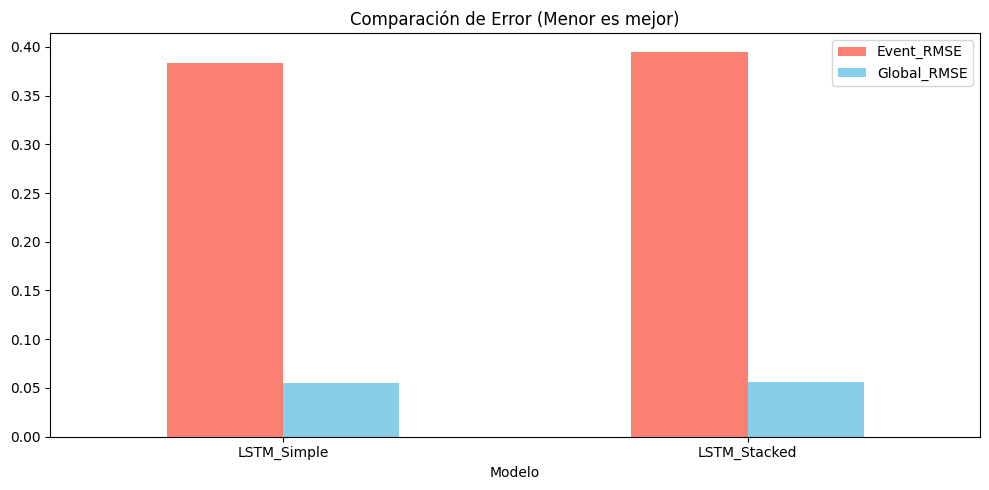

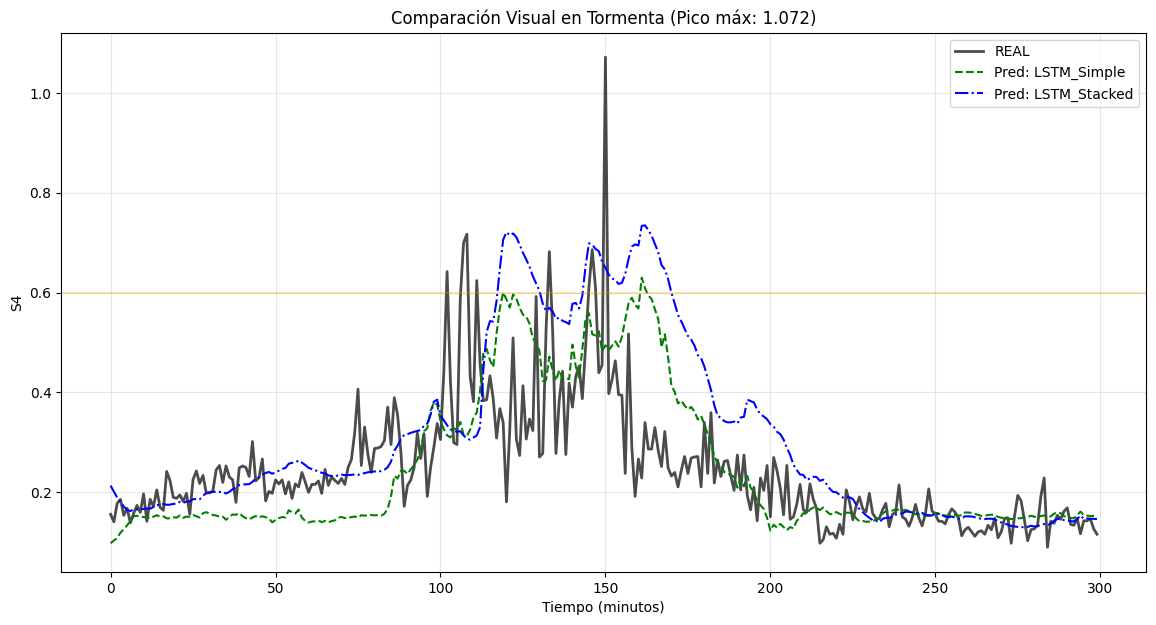

In [32]:
# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    # --- PARÁMETROS FIJOS PARA LA COMPARACIÓN ---
    # Usamos los mejores valores que hayas encontrado (o un estándar robusto)
    LOOKBACK_FIJO = 60
    HORIZON_FIJO = 10
    PENALTY_FIJO = 30.0
    
    # 1. Pipeline de Datos
    print("🚀 PREPARANDO DATOS...")
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False)
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # 2. Ejecutar Comparación
    df_resultados, preds_dict, y_real = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=0.6, penalty=PENALTY_FIJO
    )
    
    # 3. Visualizar
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real)


🏆 RANKING DE MODELOS (Ordenado por Event RMSE)
      Modelo  Global_RMSE  Event_RMSE
 LSTM_Simple     0.055071    0.383177
LSTM_Stacked     0.055751    0.394696

🥇 GANADOR: LSTM_Simple con Event RMSE = 0.3832


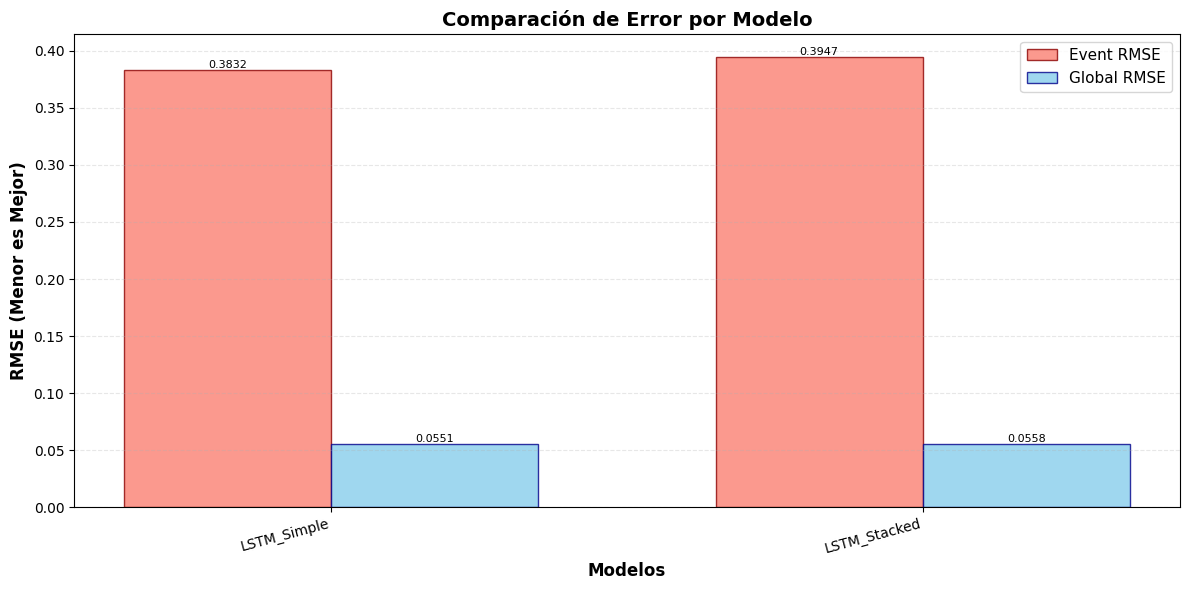


📊 Generando gráfica de serie temporal completa...


/tmp/ipykernel_207111/2791143950.py:487: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/soporte/anaconda3/envs/s4_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


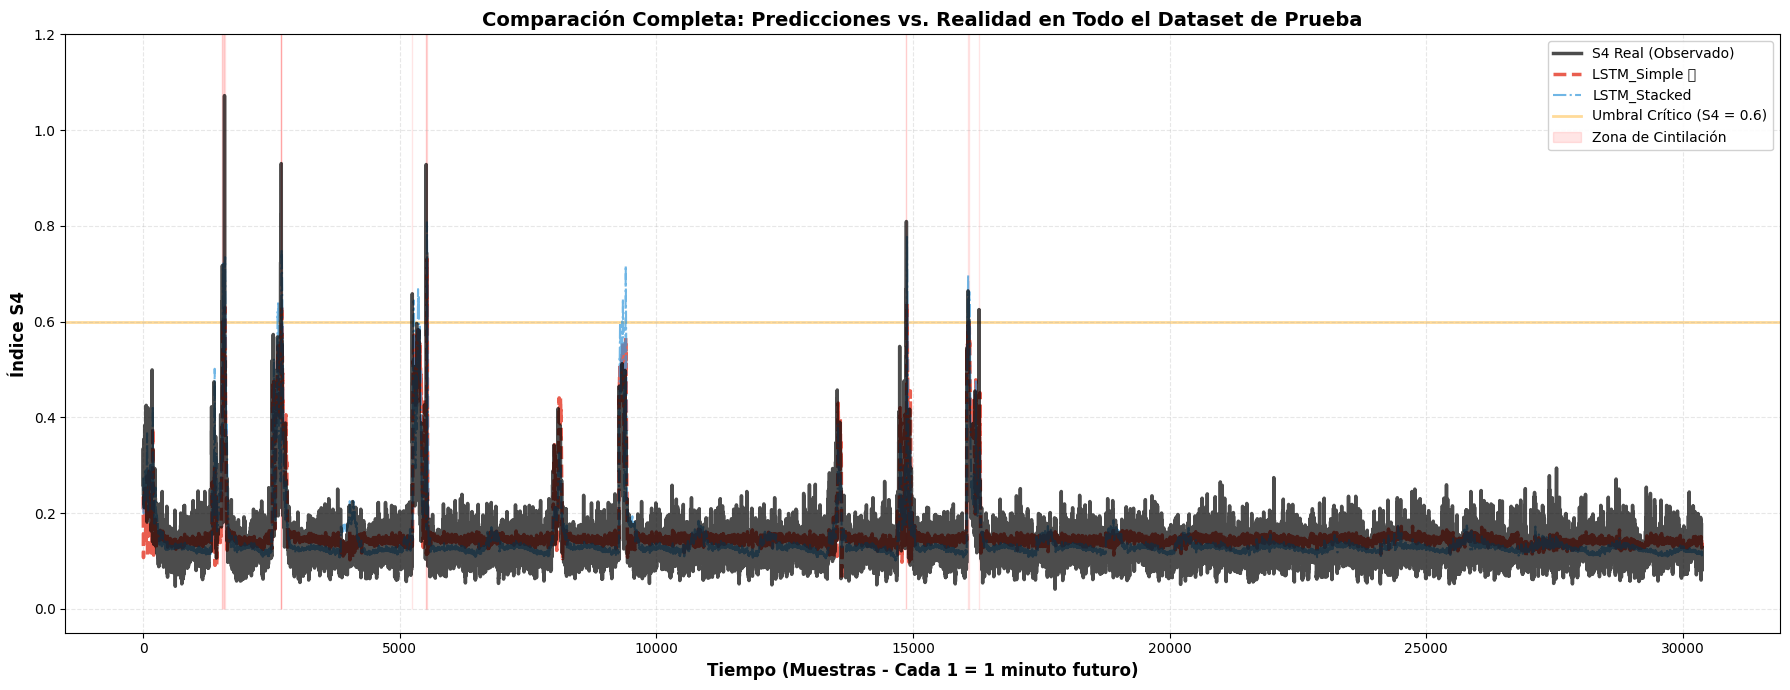


🔍 Detectando tormentas principales para zoom...
   Tormentas detectadas: 3


/tmp/ipykernel_207111/2791143950.py:577: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


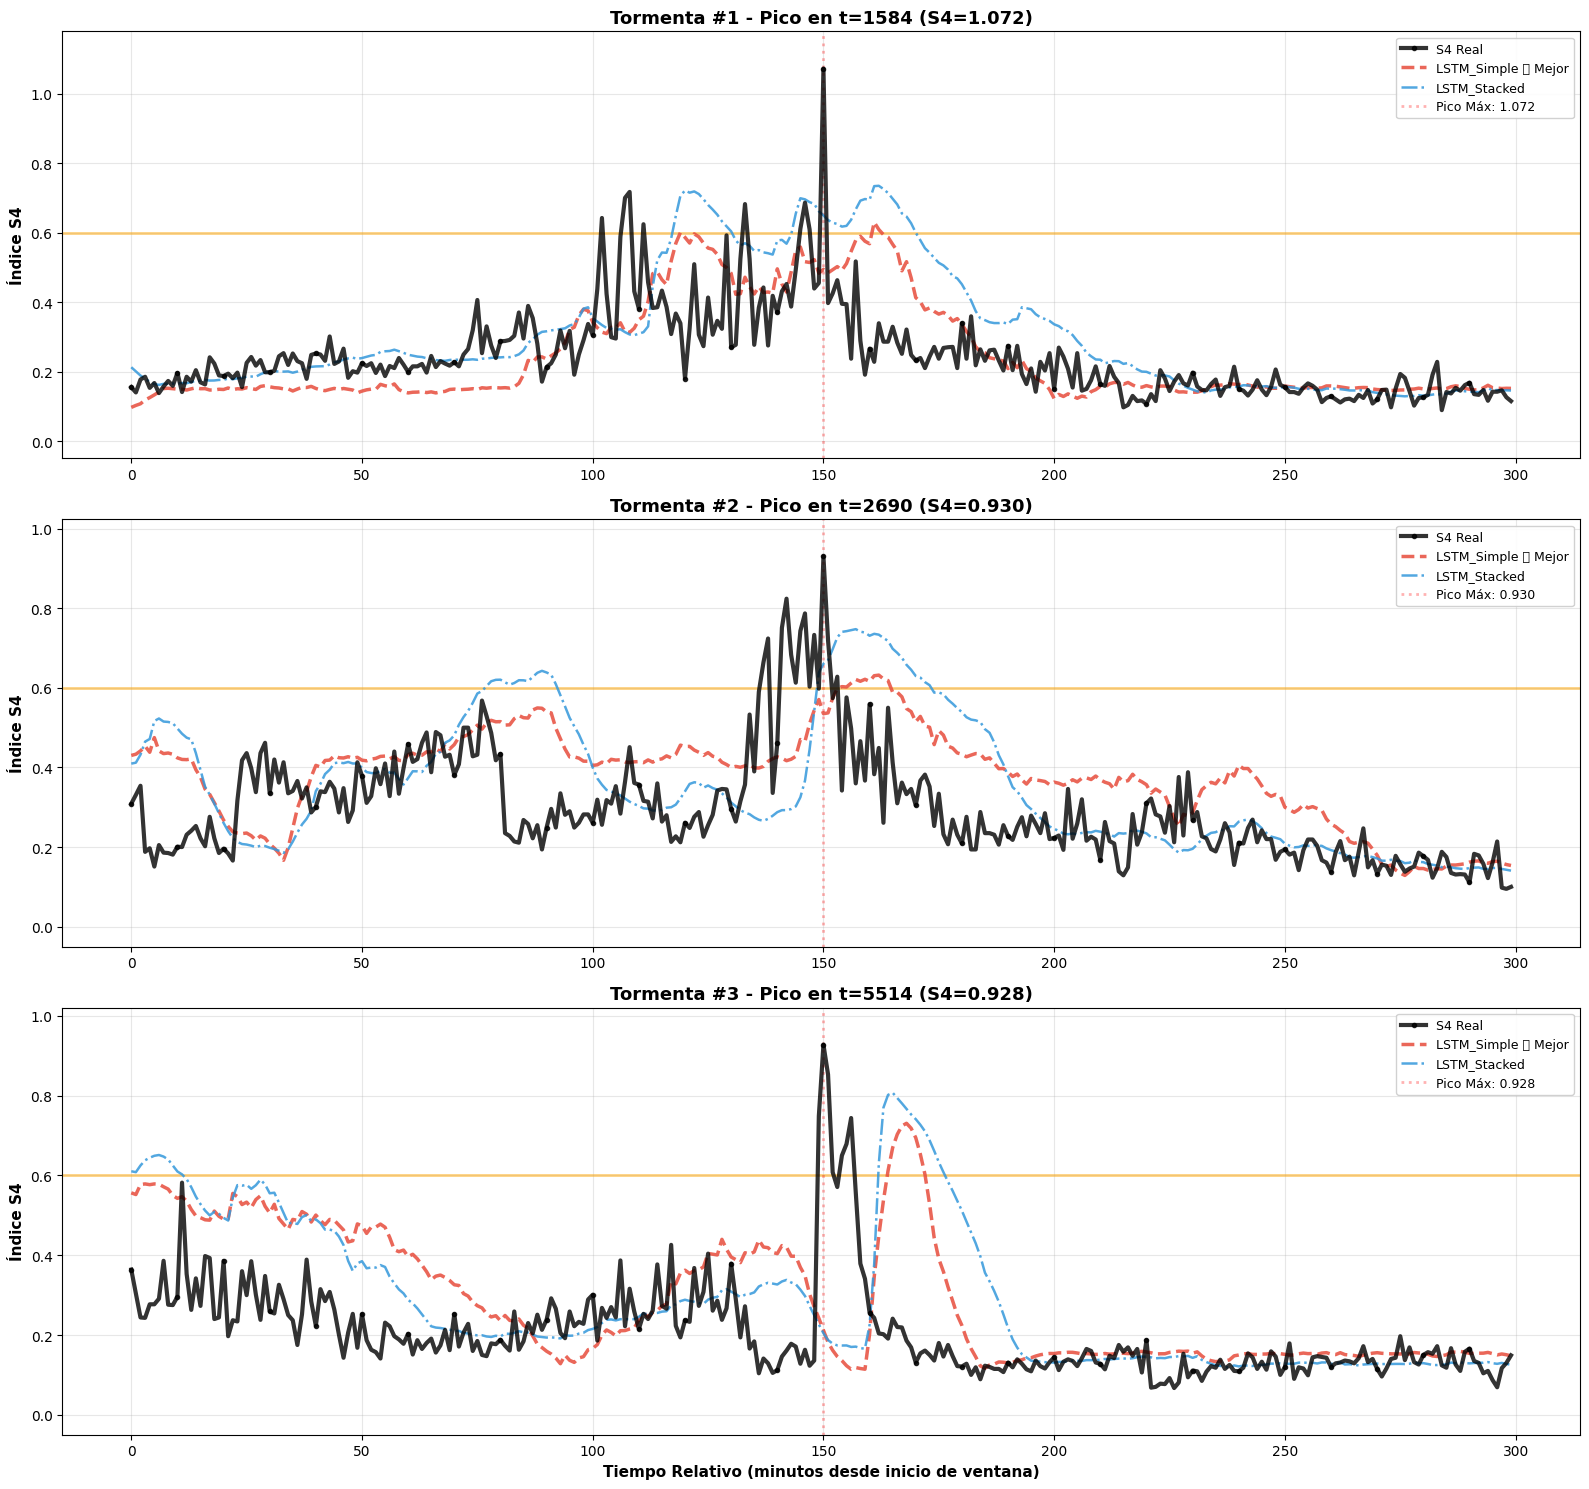

/tmp/ipykernel_207111/2791143950.py:599: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(errores_data, labels=labels, patch_artist=True, showmeans=True)
/tmp/ipykernel_207111/2791143950.py:628: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(errores_eventos_data, labels=labels_eventos,



📈 Generando análisis de distribución de errores...


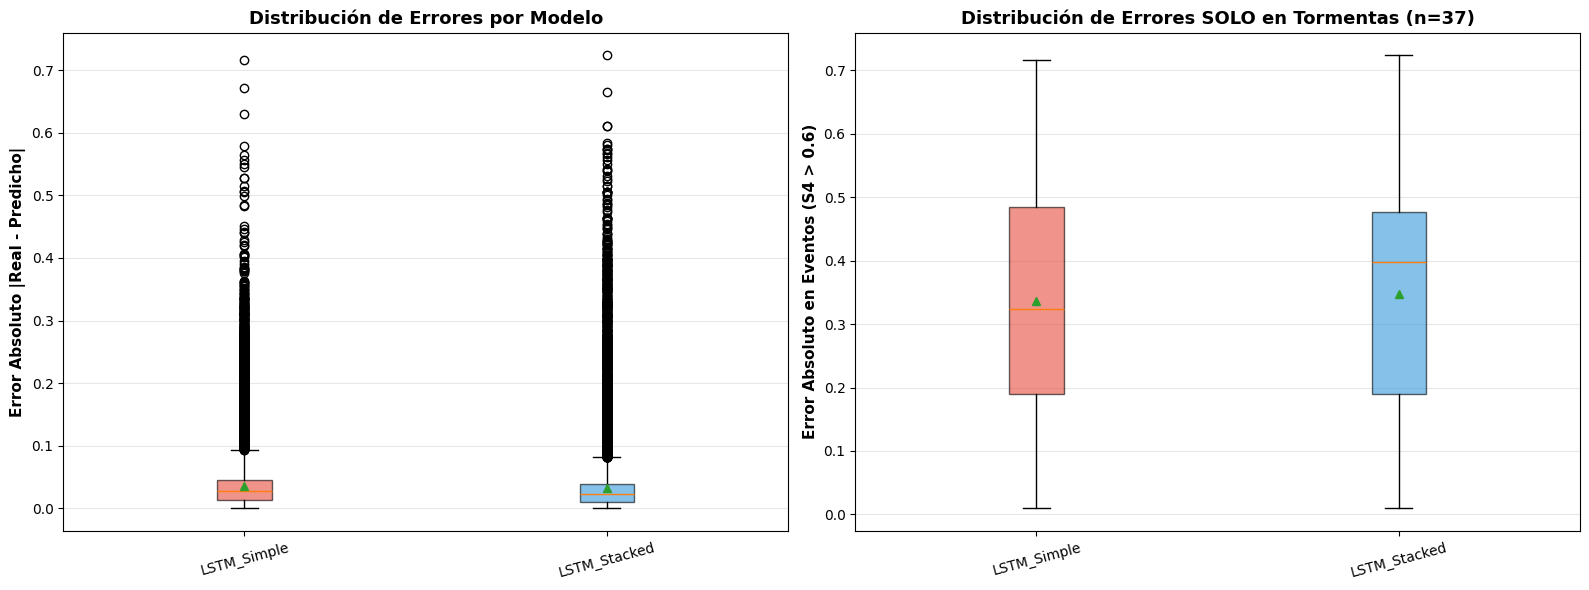


📊 RESUMEN ESTADÍSTICO DE ERRORES

LSTM_Simple:
  • Error medio global: 0.0362
  • Error mediano: 0.0277
  • Error máximo: 0.7165
  • Desv. estándar: 0.0415
  • Error medio en eventos: 0.3362
  • Error máximo en eventos: 0.7165

LSTM_Stacked:
  • Error medio global: 0.0324
  • Error mediano: 0.0223
  • Error máximo: 0.7235
  • Desv. estándar: 0.0454
  • Error medio en eventos: 0.3479
  • Error máximo en eventos: 0.7235
✅ Análisis comparativo completo finalizado.



In [38]:
graficar_comparativa_modelos_GLOBAL(df_resultados, preds_dict, y_real)

## **PRUEBA 0002**

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🔍 Analizando eventos...

🎞️ Generando Tensores (Lookback=40, Horizon=40)...
   X_train: (132431, 40, 9), y_train: (132431,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0620 | Event RMSE: 0.3605

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0615 | Event RMSE: 0.4505

🤖 Entrenando: LSTM_Bidirectional...
   📊 LSTM_Bidirectional -> Global RMSE: 0.0640 | Event RMSE: 0.3290

🏆 RANKING DE MODELOS:
            Modelo  Global_RMSE  Event_RMSE
LSTM_Bidirectional     0.064047    0.328999
       LSTM_Simple     0.062023    0.360539
      LSTM_Stacked     0.061526    0.450486


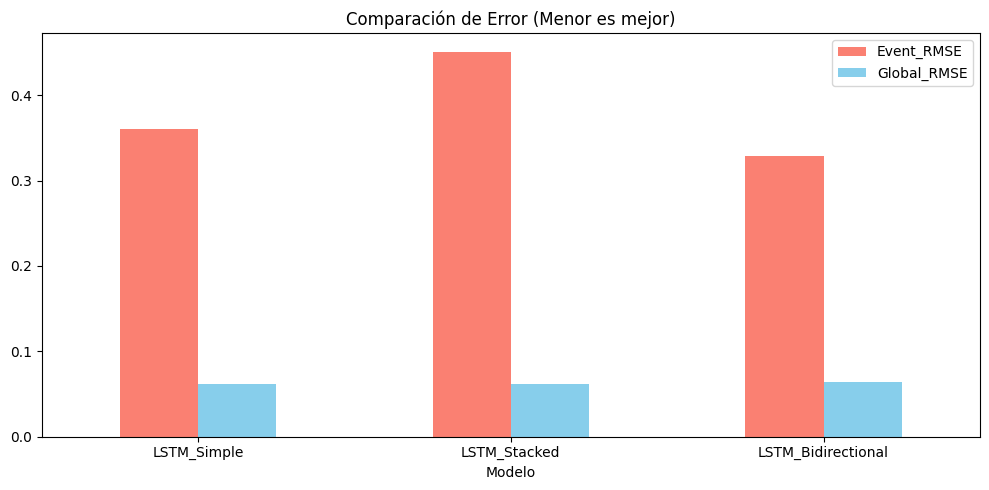

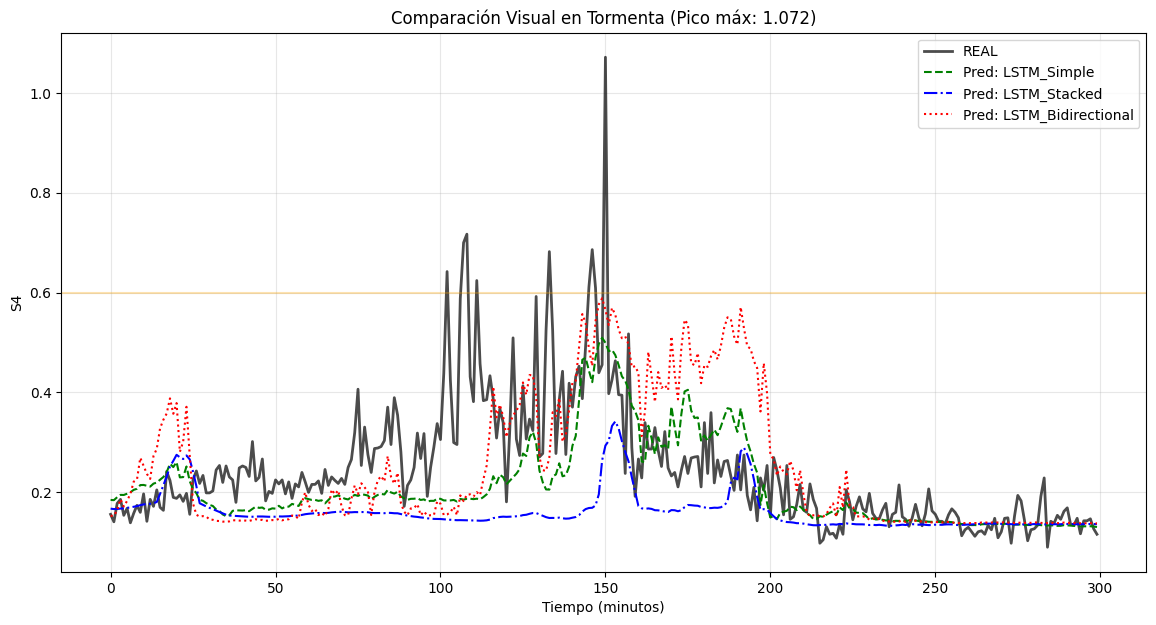

In [31]:
# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    # --- PARÁMETROS FIJOS PARA LA COMPARACIÓN ---
    # Usamos los mejores valores que hayas encontrado (o un estándar robusto)
    LOOKBACK_FIJO = 40
    HORIZON_FIJO = 40
    PENALTY_FIJO = 30.0
    
    # 1. Pipeline de Datos
    print("🚀 PREPARANDO DATOS...")
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False)
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # 2. Ejecutar Comparación
    df_resultados, preds_dict, y_real = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=0.6, penalty=PENALTY_FIJO
    )
    
    # 3. Visualizar
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real)

# **PRUEBA 0003**

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🔍 Analizando eventos...

🎞️ Generando Tensores (Lookback=60, Horizon=40)...
   X_train: (130177, 60, 9), y_train: (130177,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0626 | Event RMSE: 0.4228

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0610 | Event RMSE: 0.3409

🤖 Entrenando: LSTM_Bidirectional...
   📊 LSTM_Bidirectional -> Global RMSE: 0.0744 | Event RMSE: 0.3313

🏆 RANKING DE MODELOS:
            Modelo  Global_RMSE  Event_RMSE
LSTM_Bidirectional     0.074440    0.331268
      LSTM_Stacked     0.060967    0.340933
       LSTM_Simple     0.062618    0.422794


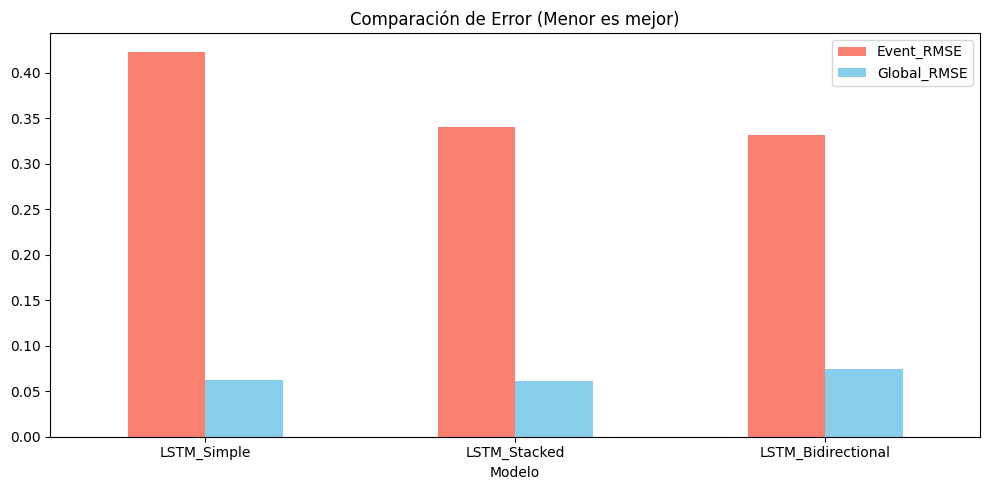

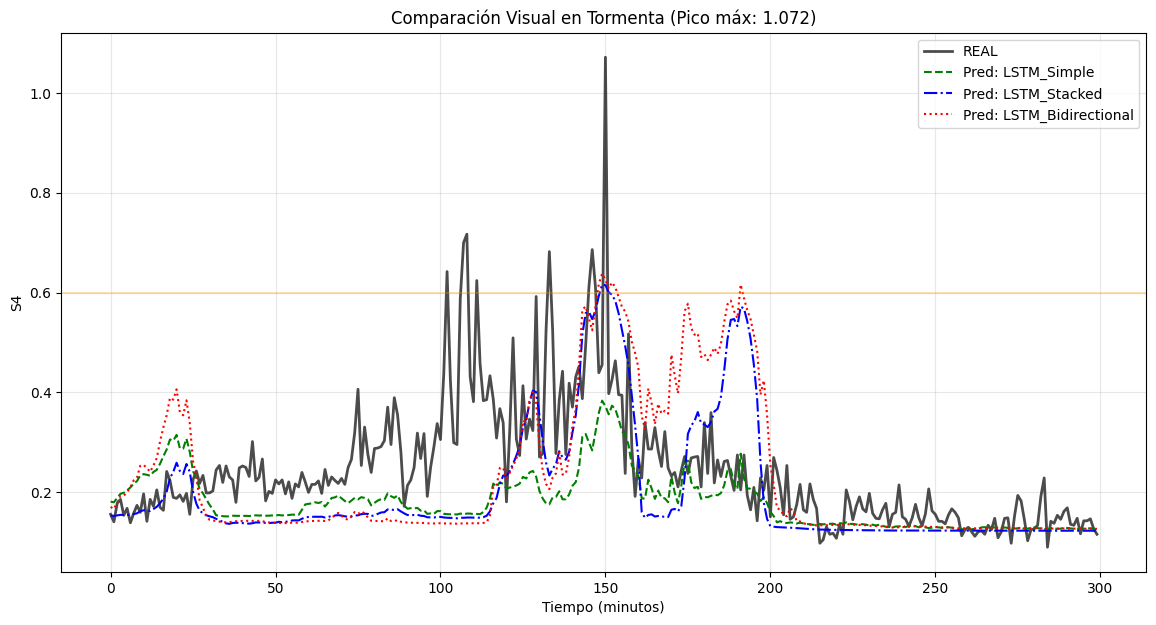

In [34]:
# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":

    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    # --- PARÁMETROS FIJOS PARA LA COMPARACIÓN ---
    # Usamos los mejores valores que hayas encontrado (o un estándar robusto)
    LOOKBACK_FIJO = 60
    HORIZON_FIJO = 40
    PENALTY_FIJO = 30.0
    
    # 1. Pipeline de Datos
    print("🚀 PREPARANDO DATOS...")
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False)
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # 2. Ejecutar Comparación
    df_resultados, preds_dict, y_real = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=0.6, penalty=PENALTY_FIJO
    )
    
    # 3. Visualizar
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real)

## **CUARTA ARQUITECTURA - MODELO Hybrid_LSTM_ELM**

In [36]:
from scipy.linalg import pinv # <--- IMPORTANTE: AGREGAR ESTO AL INICIO

# =============================================================================
# NUEVO: FUNCIÓN DE PÉRDIDA ASIMÉTRICA (Para entrenar el Backbone del Híbrido)
# =============================================================================
def get_asymmetric_peak_loss(threshold_norm, penalty_factor=25.0):
    def asymmetric_loss(y_true, y_pred):
        # 1. Error base cuadrático
        squared_error = tf.keras.backend.square(y_true - y_pred)
        
        # 2. Identificar zonas críticas (Donde S4 real > umbral)
        is_high = tf.keras.backend.greater(y_true, threshold_norm)
        
        # 3. Identificar subestimación (Predicción < Real)
        is_under = tf.keras.backend.less(y_pred, y_true)
        
        # 4. Combinar: ¿Es tormenta Y te quedaste corto?
        critical = tf.keras.backend.all(tf.stack([is_high, is_under], axis=0), axis=0)
        critical = tf.cast(critical, tf.float32)
        
        # 5. Pesos: Si es crítico, castigo x25. Si no, x1.
        weights = critical * (penalty_factor - 1) + 1
        return tf.keras.backend.mean(squared_error * weights)
    return asymmetric_loss

# =============================================================================
# NUEVO: CLASE ARQUITECTURA HÍBRIDA (MORPH-LSTM-ELM)
# =============================================================================
class Hybrid_LSTM_ELM:
    def __init__(self, input_shape, lstm_units=64, umbral_norm=0.5, penalty=25.0):
        self.input_shape = input_shape
        self.lstm_units = lstm_units
        self.umbral = umbral_norm
        self.penalty = penalty
        self.model_backbone = None
        self.feature_extractor = None
        self.beta = None # Pesos ELM
        self.name = "Hybrid_LSTM_ELM"

    def build_backbone(self):
        # Fase 1: Red LSTM que aprende características usando Loss Asimétrica
        inp = Input(shape=self.input_shape)
        # Usamos una estructura similar al LSTM Simple que fue efectivo
        x = LSTM(self.lstm_units, return_sequences=False, activation='tanh')(inp)
        # Capa temporal para permitir el entrenamiento del backbone
        out = Dense(1, name='temp_output')(x)
        
        self.model_backbone = tf.keras.models.Model(inputs=inp, outputs=out)
        
        # AQUÍ LA CLAVE: Compilamos con la pérdida asimétrica
        # Esto fuerza a la LSTM a extraer características enfocadas en los picos
        loss_fn = get_asymmetric_peak_loss(self.umbral, self.penalty)
        self.model_backbone.compile(optimizer='adam', loss=loss_fn)

    def train_backbone(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        print(f"   ⚙️ [Fase 1] Entrenando Backbone con Asymmetric Loss...")
        # Early stopping para no sobreajustar la fase 1
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        self.model_backbone.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[es],
            verbose=0
        )
        # Crear extractor cortando la cabeza densa
        self.feature_extractor = tf.keras.models.Model(
            inputs=self.model_backbone.input, 
            outputs=self.model_backbone.layers[-2].output # Capa LSTM
        )

    def solve_elm(self, X_train, y_train):
        print(f"   ⚡ [Fase 2] Resolviendo ELM (Pseudoinversa)...")
        # 1. Obtener matriz H (Features latentes)
        H = self.feature_extractor.predict(X_train, verbose=0)
        
        # 2. Agregar Bias (Trick de álgebra lineal)
        num_samples = H.shape[0]
        bias_col = np.ones((num_samples, 1))
        H_bias = np.hstack((H, bias_col))
        
        # 3. Calcular Beta = pinv(H) * T
        # pinv calcula la solución de mínimos cuadrados (MSE óptimo)
        H_pinv = pinv(H_bias)
        if len(y_train.shape) == 1: y_train = y_train.reshape(-1, 1)
        self.beta = np.dot(H_pinv, y_train)

    def predict(self, X_test):
        H_test = self.feature_extractor.predict(X_test, verbose=0)
        bias_col = np.ones((H_test.shape[0], 1))
        H_test_bias = np.hstack((H_test, bias_col))
        return np.dot(H_test_bias, self.beta)

# **PRUEBA ELM 0001**

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🎞️ Generando Tensores (Lookback=60, Horizon=40)...
   X_train: (130177, 60, 9), y_train: (130177,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0662 | Event RMSE: 0.3785

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0676 | Event RMSE: 0.3705

🤖 Entrenando: LSTM_Bidirectional...
   📊 LSTM_Bidirectional -> Global RMSE: 0.0579 | Event RMSE: 0.3712

🤖 Entrenando: Hybrid_LSTM_ELM (Propuesto)...
   ⚙️ [Fase 1] Entrenando Backbone con Asymmetric Loss...
   ⚡ [Fase 2] Resolviendo ELM (Pseudoinversa)...
   📊 Hybrid_LSTM_ELM -> Global RMSE: 0.0456 | Event RMSE: 0.4590

🏆 RANKING DE MODELOS:
            Modelo  Global_RMSE  Event_RMSE
      LSTM_Stacked     0.067575    0.370532
LSTM_Bidirectional     0.057869    0.371242
       LSTM_Simple     0.066214    0.378488
   Hybrid_LSTM_ELM     0.045573    0.459047


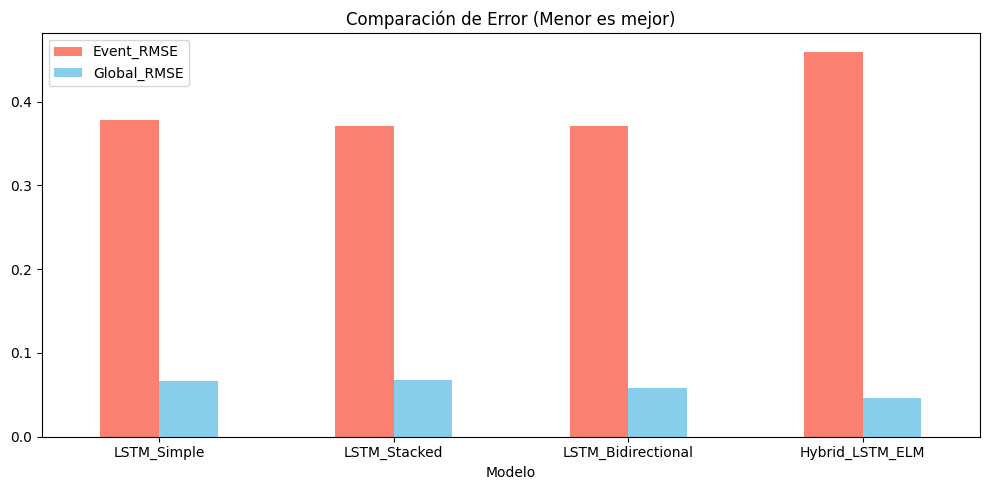

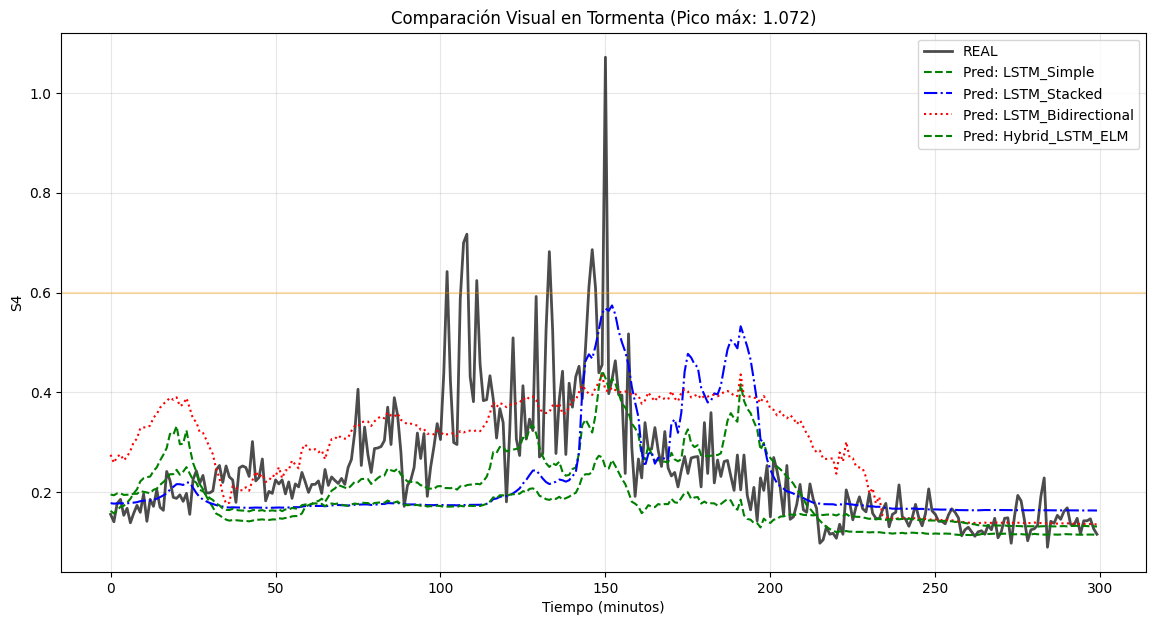


✅ PROCESO COMPLETADO.

--- COMENTARIO TÉCNICO SOBRE EL HÍBRIDO ---
Observa si 'Hybrid_LSTM_ELM' reduce el Event_RMSE comparado con 'LSTM_Simple'.
La fase 1 usó Loss Asimétrica para aprender características de picos,
y la fase 2 usó ELM para el ajuste fino matemático.


In [39]:
# =============================================================================
# MAIN (ACTUALIZADO CON ARQUITECTURA HÍBRIDA)
# =============================================================================
if __name__ == "__main__":
    
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook" # Ajusta si es necesario
    ARCHIVO = "df_FINAL.csv" # Asegúrate que el archivo exista
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    LOOKBACK_FIJO = 60
    HORIZON_FIJO = 40  # Horizonte exigente
    PENALTY_FIJO = 30.0 # Castigo fuerte a la subestimación
    UMBRAL_S4_REAL = 0.6

    # 1. Pipeline de Datos (Igual que siempre)
    print("🚀 PREPARANDO DATOS...")
    try:
        df_raw = cargar_dataset(RUTA, ARCHIVO)
    except Exception as e:
        # Generar dummy data si no hay archivo para probar el código
        print(f"⚠️ {e}. Generando datos sintéticos para prueba...")
        fechas = pd.date_range("2025-01-01", periods=5000, freq="T")
        df_raw = pd.DataFrame(index=fechas)
        df_raw["Tiempo"] = fechas
        df_raw["S4"] = np.abs(np.sin(np.linspace(0, 100, 5000))) + np.random.normal(0, 0.1, 5000)
        for c in FEATURES: 
            if c not in df_raw.columns: df_raw[c] = np.random.rand(5000)
        df_raw = df_raw.sort_values("Tiempo")

    # Procesamiento
    # analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False) # Opcional
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # -----------------------------------------------------------
    # PASO A: Ejecutar Benchmark de Modelos Keras Estándar
    # -----------------------------------------------------------
    df_resultados, preds_dict, y_real_desnorm = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=UMBRAL_S4_REAL, penalty=PENALTY_FIJO
    )

    # -----------------------------------------------------------
    # PASO B: Ejecutar Arquitectura Híbrida (MANUALMENTE)
    # -----------------------------------------------------------
    print("\n🤖 Entrenando: Hybrid_LSTM_ELM (Propuesto)...")
    
    # Calcular umbral normalizado para la loss interna
    idx_s4 = FEATURES.index('S4')
    vmin, vmax = scaler.data_min_[idx_s4], scaler.data_max_[idx_s4]
    umbral_norm = (UMBRAL_S4_REAL - vmin) / (vmax - vmin)

    # 1. Instanciar
    # Usamos 64 unidades (similar al LSTM Simple que funcionó bien)
    hybrid_model = Hybrid_LSTM_ELM(input_shape=(Xt.shape[1], Xt.shape[2]), 
                                   lstm_units=64, 
                                   umbral_norm=umbral_norm, 
                                   penalty=PENALTY_FIJO)
    
    # 2. Construir y Entrenar Fase 1 (Backbone con Asymmetric Loss)
    hybrid_model.build_backbone()
    hybrid_model.train_backbone(Xt, yt, Xv, yv, epochs=30, batch_size=32)
    
    # 3. Resolver Fase 2 (ELM)
    hybrid_model.solve_elm(Xt, yt)
    
    # 4. Predecir y Evaluar
    y_pred_h_raw = hybrid_model.predict(Xte)
    y_pred_h_real = desnormalizar(y_pred_h_raw, scaler, FEATURES, 'S4')
    
    # Guardar en diccionario de predicciones
    preds_dict["Hybrid_LSTM_ELM"] = y_pred_h_real
    
    # Calcular métricas
    rmse_g_h, rmse_e_h = calcular_metricas(y_real_desnorm, y_pred_h_real, UMBRAL_S4_REAL)
    print(f"   📊 Hybrid_LSTM_ELM -> Global RMSE: {rmse_g_h:.4f} | Event RMSE: {rmse_e_h:.4f}")
    
    # Agregar a la tabla de resultados
    nuevo_res = pd.DataFrame([{
        "Modelo": "Hybrid_LSTM_ELM",
        "Global_RMSE": rmse_g_h,
        "Event_RMSE": rmse_e_h
    }])
    df_resultados = pd.concat([df_resultados, nuevo_res], ignore_index=True)

    # -----------------------------------------------------------
    # PASO C: Visualización Final
    # -----------------------------------------------------------
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real_desnorm)
    
    print("\n✅ PROCESO COMPLETADO.")
    
    # Comentario final para tu análisis:
    print("\n--- COMENTARIO TÉCNICO SOBRE EL HÍBRIDO ---")
    print("Observa si 'Hybrid_LSTM_ELM' reduce el Event_RMSE comparado con 'LSTM_Simple'.")
    print("La fase 1 usó Loss Asimétrica para aprender características de picos,")
    print("y la fase 2 usó ELM para el ajuste fino matemático.")

# **PRUEBA ELM 0002**

In [ ]:
# =============================================================================
# MAIN (ACTUALIZADO CON ARQUITECTURA HÍBRIDA)
# =============================================================================
if __name__ == "__main__":
    
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook" # Ajusta si es necesario
    ARCHIVO = "df_FINAL.csv" # Asegúrate que el archivo exista
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    LOOKBACK_FIJO = 60
    HORIZON_FIJO = 20  # Horizonte exigente
    PENALTY_FIJO = 30.0 # Castigo fuerte a la subestimación
    UMBRAL_S4_REAL = 0.6

    # 1. Pipeline de Datos (Igual que siempre)
    print("🚀 PREPARANDO DATOS...")
    try:
        df_raw = cargar_dataset(RUTA, ARCHIVO)
    except Exception as e:
        # Generar dummy data si no hay archivo para probar el código
        print(f"⚠️ {e}. Generando datos sintéticos para prueba...")
        fechas = pd.date_range("2025-01-01", periods=5000, freq="T")
        df_raw = pd.DataFrame(index=fechas)
        df_raw["Tiempo"] = fechas
        df_raw["S4"] = np.abs(np.sin(np.linspace(0, 100, 5000))) + np.random.normal(0, 0.1, 5000)
        for c in FEATURES: 
            if c not in df_raw.columns: df_raw[c] = np.random.rand(5000)
        df_raw = df_raw.sort_values("Tiempo")

    # Procesamiento
    # analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False) # Opcional
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # -----------------------------------------------------------
    # PASO A: Ejecutar Benchmark de Modelos Keras Estándar
    # -----------------------------------------------------------
    df_resultados, preds_dict, y_real_desnorm = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=UMBRAL_S4_REAL, penalty=PENALTY_FIJO
    )

    # -----------------------------------------------------------
    # PASO B: Ejecutar Arquitectura Híbrida (MANUALMENTE)
    # -----------------------------------------------------------
    print("\n🤖 Entrenando: Hybrid_LSTM_ELM (Propuesto)...")
    
    # Calcular umbral normalizado para la loss interna
    idx_s4 = FEATURES.index('S4')
    vmin, vmax = scaler.data_min_[idx_s4], scaler.data_max_[idx_s4]
    umbral_norm = (UMBRAL_S4_REAL - vmin) / (vmax - vmin)

    # 1. Instanciar
    # Usamos 64 unidades (similar al LSTM Simple que funcionó bien)
    hybrid_model = Hybrid_LSTM_ELM(input_shape=(Xt.shape[1], Xt.shape[2]), 
                                   lstm_units=64, 
                                   umbral_norm=umbral_norm, 
                                   penalty=PENALTY_FIJO)
    
    # 2. Construir y Entrenar Fase 1 (Backbone con Asymmetric Loss)
    hybrid_model.build_backbone()
    hybrid_model.train_backbone(Xt, yt, Xv, yv, epochs=30, batch_size=32)
    
    # 3. Resolver Fase 2 (ELM)
    hybrid_model.solve_elm(Xt, yt)
    
    # 4. Predecir y Evaluar
    y_pred_h_raw = hybrid_model.predict(Xte)
    y_pred_h_real = desnormalizar(y_pred_h_raw, scaler, FEATURES, 'S4')
    
    # Guardar en diccionario de predicciones
    preds_dict["Hybrid_LSTM_ELM"] = y_pred_h_real
    
    # Calcular métricas
    rmse_g_h, rmse_e_h = calcular_metricas(y_real_desnorm, y_pred_h_real, UMBRAL_S4_REAL)
    print(f"   📊 Hybrid_LSTM_ELM -> Global RMSE: {rmse_g_h:.4f} | Event RMSE: {rmse_e_h:.4f}")
    
    # Agregar a la tabla de resultados
    nuevo_res = pd.DataFrame([{
        "Modelo": "Hybrid_LSTM_ELM",
        "Global_RMSE": rmse_g_h,
        "Event_RMSE": rmse_e_h
    }])
    df_resultados = pd.concat([df_resultados, nuevo_res], ignore_index=True)

    # -----------------------------------------------------------
    # PASO C: Visualización Final
    # -----------------------------------------------------------
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real_desnorm)
    
    print("\n✅ PROCESO COMPLETADO.")
    
    # Comentario final para tu análisis:
    print("\n--- COMENTARIO TÉCNICO SOBRE EL HÍBRIDO ---")
    print("Observa si 'Hybrid_LSTM_ELM' reduce el Event_RMSE comparado con 'LSTM_Simple'.")
    print("La fase 1 usó Loss Asimétrica para aprender características de picos,")
    print("y la fase 2 usó ELM para el ajuste fino matemático.")

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🎞️ Generando Tensores (Lookback=60, Horizon=20)...
   X_train: (132431, 60, 9), y_train: (132431,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0586 | Event RMSE: 0.3603

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0702 | Event RMSE: 0.3371

🤖 Entrenando: LSTM_Bidirectional...


# **PRUEBA ELM 0003**

🚀 PREPARANDO DATOS...
📂 Cargando archivo: df_FINAL.csv...

🎞️ Generando Tensores (Lookback=90, Horizon=20)...
   X_train: (129067, 90, 9), y_train: (129067,)

🏁 INICIANDO BENCHMARK DE MODELOS...

🤖 Entrenando: LSTM_Simple...
   📊 LSTM_Simple -> Global RMSE: 0.0527 | Event RMSE: 0.3863

🤖 Entrenando: LSTM_Stacked...
   📊 LSTM_Stacked -> Global RMSE: 0.0507 | Event RMSE: 0.4525

🤖 Entrenando: LSTM_Bidirectional...
   📊 LSTM_Bidirectional -> Global RMSE: 0.0541 | Event RMSE: 0.3724

🤖 Entrenando: Hybrid_LSTM_ELM (Propuesto)...
   ⚙️ [Fase 1] Entrenando Backbone con Asymmetric Loss...
   ⚡ [Fase 2] Resolviendo ELM (Pseudoinversa)...
   📊 Hybrid_LSTM_ELM -> Global RMSE: 0.0423 | Event RMSE: 0.4730

🏆 RANKING DE MODELOS:
            Modelo  Global_RMSE  Event_RMSE
LSTM_Bidirectional     0.054071    0.372411
       LSTM_Simple     0.052668    0.386281
      LSTM_Stacked     0.050731    0.452515
   Hybrid_LSTM_ELM     0.042318    0.473038


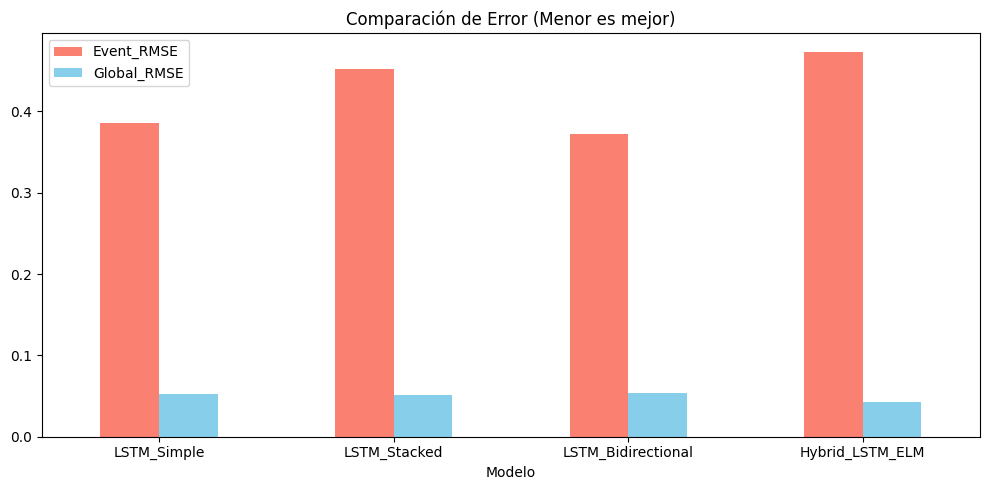

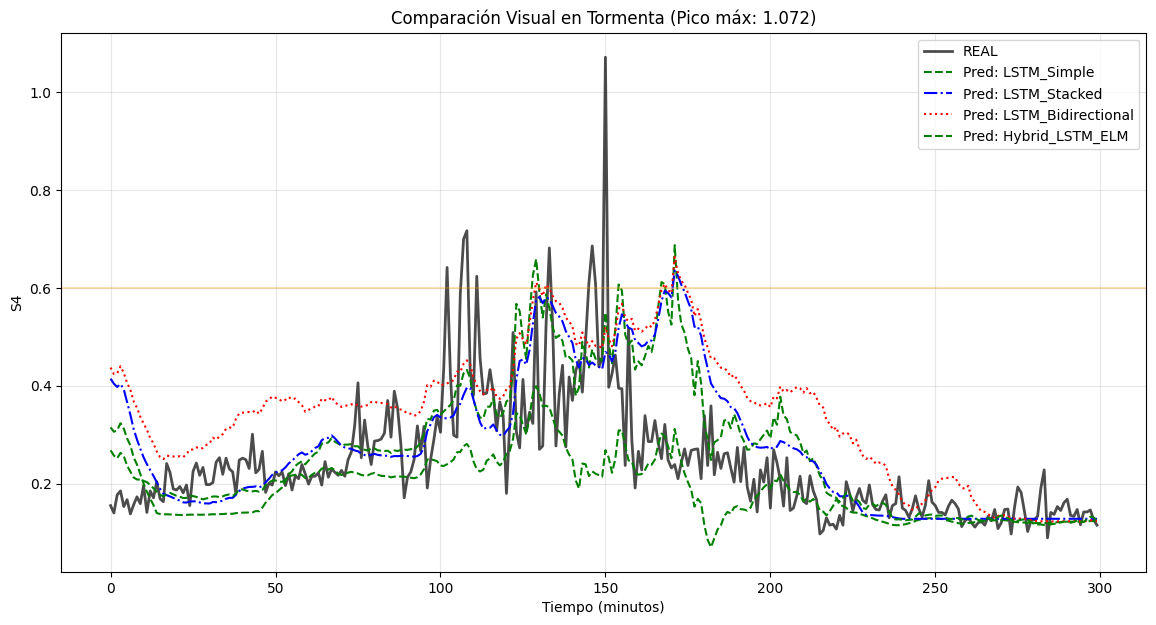


✅ PROCESO COMPLETADO.

--- COMENTARIO TÉCNICO SOBRE EL HÍBRIDO ---
Observa si 'Hybrid_LSTM_ELM' reduce el Event_RMSE comparado con 'LSTM_Simple'.
La fase 1 usó Loss Asimétrica para aprender características de picos,
y la fase 2 usó ELM para el ajuste fino matemático.


In [103]:
# =============================================================================
# MAIN (ACTUALIZADO CON ARQUITECTURA HÍBRIDA)
# =============================================================================
if __name__ == "__main__":
    
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook" # Ajusta si es necesario
    ARCHIVO = "df_FINAL.csv" # Asegúrate que el archivo exista
    FEATURES = ['S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 'Hora_Sin', 'Hora_Cos']
    
    LOOKBACK_FIJO = 90
    HORIZON_FIJO = 20  # Horizonte exigente
    PENALTY_FIJO = 30.0 # Castigo fuerte a la subestimación
    UMBRAL_S4_REAL = 0.6

    # 1. Pipeline de Datos (Igual que siempre)
    print("🚀 PREPARANDO DATOS...")
    try:
        df_raw = cargar_dataset(RUTA, ARCHIVO)
    except Exception as e:
        # Generar dummy data si no hay archivo para probar el código
        print(f"⚠️ {e}. Generando datos sintéticos para prueba...")
        fechas = pd.date_range("2025-01-01", periods=5000, freq="T")
        df_raw = pd.DataFrame(index=fechas)
        df_raw["Tiempo"] = fechas
        df_raw["S4"] = np.abs(np.sin(np.linspace(0, 100, 5000))) + np.random.normal(0, 0.1, 5000)
        for c in FEATURES: 
            if c not in df_raw.columns: df_raw[c] = np.random.rand(5000)
        df_raw = df_raw.sort_values("Tiempo")

    # Procesamiento
    # analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=False) # Opcional
    df_feat = agregar_caracteristicas_temporales(df_raw)
    df_fin = finalizar_estructura_df(df_feat)
    
    tr_df, va_df, te_df = dividir_estratificado_por_dias(df_fin)
    tr_s, va_s, te_s, scaler = normalizar_sets(tr_df, va_df, te_df, FEATURES)
    
    Xt, yt, Xv, yv, Xte, yte = generar_tensores(
        tr_s, va_s, te_s, FEATURES, 'S4', LOOKBACK_FIJO, HORIZON_FIJO
    )
    
    # -----------------------------------------------------------
    # PASO A: Ejecutar Benchmark de Modelos Keras Estándar
    # -----------------------------------------------------------
    df_resultados, preds_dict, y_real_desnorm = ejecutar_benchmark_modelos(
        Xt, yt, Xv, yv, Xte, yte, 
        scaler, FEATURES, 
        umbral_real=UMBRAL_S4_REAL, penalty=PENALTY_FIJO
    )

    # -----------------------------------------------------------
    # PASO B: Ejecutar Arquitectura Híbrida (MANUALMENTE)
    # -----------------------------------------------------------
    print("\n🤖 Entrenando: Hybrid_LSTM_ELM (Propuesto)...")
    
    # Calcular umbral normalizado para la loss interna
    idx_s4 = FEATURES.index('S4')
    vmin, vmax = scaler.data_min_[idx_s4], scaler.data_max_[idx_s4]
    umbral_norm = (UMBRAL_S4_REAL - vmin) / (vmax - vmin)

    # 1. Instanciar
    # Usamos 64 unidades (similar al LSTM Simple que funcionó bien)
    hybrid_model = Hybrid_LSTM_ELM(input_shape=(Xt.shape[1], Xt.shape[2]), 
                                   lstm_units=64, 
                                   umbral_norm=umbral_norm, 
                                   penalty=PENALTY_FIJO)
    
    # 2. Construir y Entrenar Fase 1 (Backbone con Asymmetric Loss)
    hybrid_model.build_backbone()
    hybrid_model.train_backbone(Xt, yt, Xv, yv, epochs=30, batch_size=32)
    
    # 3. Resolver Fase 2 (ELM)
    hybrid_model.solve_elm(Xt, yt)
    
    # 4. Predecir y Evaluar
    y_pred_h_raw = hybrid_model.predict(Xte)
    y_pred_h_real = desnormalizar(y_pred_h_raw, scaler, FEATURES, 'S4')
    
    # Guardar en diccionario de predicciones
    preds_dict["Hybrid_LSTM_ELM"] = y_pred_h_real
    
    # Calcular métricas
    rmse_g_h, rmse_e_h = calcular_metricas(y_real_desnorm, y_pred_h_real, UMBRAL_S4_REAL)
    print(f"   📊 Hybrid_LSTM_ELM -> Global RMSE: {rmse_g_h:.4f} | Event RMSE: {rmse_e_h:.4f}")
    
    # Agregar a la tabla de resultados
    nuevo_res = pd.DataFrame([{
        "Modelo": "Hybrid_LSTM_ELM",
        "Global_RMSE": rmse_g_h,
        "Event_RMSE": rmse_e_h
    }])
    df_resultados = pd.concat([df_resultados, nuevo_res], ignore_index=True)

    # -----------------------------------------------------------
    # PASO C: Visualización Final
    # -----------------------------------------------------------
    graficar_comparativa_modelos(df_resultados, preds_dict, y_real_desnorm)
    
    print("\n✅ PROCESO COMPLETADO.")
    
    # Comentario final para tu análisis:
    print("\n--- COMENTARIO TÉCNICO SOBRE EL HÍBRIDO ---")
    print("Observa si 'Hybrid_LSTM_ELM' reduce el Event_RMSE comparado con 'LSTM_Simple'.")
    print("La fase 1 usó Loss Asimétrica para aprender características de picos,")
    print("y la fase 2 usó ELM para el ajuste fino matemático.")